## Housing Price Prediction at Ames, Iowa
---

# Business Understanding

Price of a house depends on various attributes of the house including but not limited to area of the house, number of floors, number of bedrooms, materials used to build the house, location, proximity to various services, etc. The data provided (from this [Kaggle Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)) contains most of these aspects of resedential homes in Ames, Iowa which can be used to determine the selling price of a house. This is precisely the endeavour of the current undertaking.

# Library and Data Imports

In [1]:
## Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Imports for Data Preprocessing
from sklearn.preprocessing import StandardScaler

## Imports for Model Building
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor

## Imports for Model Evaluation
from sklearn.metrics import mean_squared_error

In [2]:
## Displaying the Data Dictionary for Reference
with open("data_description.txt", 'r') as dd:
    data_dictionary = dd.read()

print(data_dictionary)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print("Shape of the training dataset is:", train_data.shape)
print("Shape of the test dataset is:", test_data.shape)

# Displaying the head of the datasets
print("\nTraining Dataset:")
display(train_data.head(3))
print("\nTest Dataset:")
display(test_data.head(3))

Shape of the training dataset is: (1460, 81)
Shape of the test dataset is: (1459, 80)

Training Dataset:


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  

[3 rows x 81 columns]


Test Dataset:


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  

[3 rows x 80 columns]

We observe that there are 79 features that can be used to predict the price of a house. There is an `Id` column which contains the house ID in both train and test datasets which is not essentially a feature. There is an additional `SalePrice` column in the training dataset which is our dependent variable to be predicted by our final model.

## Data Understanding

Initial inspection of the dataset shows that there are multiple columns with `NaN` values which necessitate data cleaning and missing value handling. There are also categorical columns such as `MSSubClass` which have categorical values as numeric labels, so they must be carefully and correctly handled as categorical columns and the labels must not be used as numerical variables.

There are also multiple categorical variables with object type categories but belonging to a qualitative rating, so they can be converted to numerical ratings because those ratings themself have a value that can be quantified, so they must also be converted accordingly. 

`Condition1` and `Condition2` columns have represent proximity to various conditions, but they represent the same attribute and `Condition2` column is only populated for houses with multiple conditions. Therefore these variables can be converted using one-hot encoding but since `Condition2` may have many Null values, a single encoding must be made to capture presence/absence of conditions from both these columns.

The understanding mentioned above is not exhaustive and more detailed analysis will be done on each feature at a later stage to process it and use it correctly in model building.

# Data Cleaning

## Dropping Columns with High Percentage of Missing Values

In [4]:
print(round(100*train_data.isna().mean(), 2).sort_values(ascending=False).head(20))

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageYrBlt      5.55
GarageCond       5.55
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtQual         2.53
BsmtCond         2.53
BsmtFinType1     2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
Id               0.00
dtype: float64


In [5]:
print(round(100*test_data.isna().mean(), 2).sort_values(ascending=False).head(35))

PoolQC          99.79
MiscFeature     96.50
Alley           92.67
Fence           80.12
FireplaceQu     50.03
LotFrontage     15.56
GarageYrBlt      5.35
GarageQual       5.35
GarageFinish     5.35
GarageCond       5.35
GarageType       5.21
BsmtCond         3.08
BsmtQual         3.02
BsmtExposure     3.02
BsmtFinType1     2.88
BsmtFinType2     2.88
MasVnrType       1.10
MasVnrArea       1.03
MSZoning         0.27
BsmtHalfBath     0.14
Utilities        0.14
Functional       0.14
BsmtFullBath     0.14
BsmtFinSF1       0.07
BsmtFinSF2       0.07
BsmtUnfSF        0.07
KitchenQual      0.07
TotalBsmtSF      0.07
Exterior2nd      0.07
GarageCars       0.07
Exterior1st      0.07
GarageArea       0.07
SaleType         0.07
MiscVal          0.00
BedroomAbvGr     0.00
dtype: float64


The above displayed outputs contain the percentages of null values in the train and test datasets. Since we have 79 attributes in total, we choose to drop all columns with over 45% null values because these columns have too much missing data to be useful in our analysis. 

In [6]:
missing_percentage = train_data.isna().mean()*100

columns_to_drop = missing_percentage[missing_percentage > 45].index.tolist()

# Drop columns with more than 45% missing values
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

print("Shape of the dataframe after dropping the columns with high missing percentages.")
print("Training dataset shape:", train_data.shape)
print("Test dataset shape:", test_data.shape)

Shape of the dataframe after dropping the columns with high missing percentages.
Training dataset shape: (1460, 76)
Test dataset shape: (1459, 75)


## Dropping ID column

In [7]:
# Dropping Id columns
train_data.drop("Id", axis=1, inplace=True)
test_id = test_data.Id     ## Saving ID column because it is needed in submission
test_data.drop("Id", axis = 1, inplace=True)

print("Shape of the dataframe after dropping ID column.")
print("Training dataset shape:", train_data.shape)
print("Test dataset shape:", test_data.shape)

Shape of the dataframe after dropping ID column.
Training dataset shape: (1460, 75)
Test dataset shape: (1459, 74)


## Handling Missing Values

In [8]:
print(round(100*train_data.isna().mean(), 2).sort_values(ascending=False).head(15))

train_cols_with_missing = list(round(100*train_data.isna().mean(), 2).sort_values(ascending=False).head(14).index)

LotFrontage     17.74
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtQual         2.53
BsmtCond         2.53
BsmtFinType1     2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
KitchenAbvGr     0.00
dtype: float64


In [9]:
# Inspecting Data types of columns with missing values in Training Data
display(train_data[train_cols_with_missing].head(3))
print(train_data[train_cols_with_missing].info())

LotFrontage GarageType  GarageYrBlt GarageFinish GarageQual GarageCond  \
0         65.0     Attchd       2003.0          RFn         TA         TA   
1         80.0     Attchd       1976.0          RFn         TA         TA   
2         68.0     Attchd       2001.0          RFn         TA         TA   

  BsmtFinType2 BsmtExposure BsmtQual BsmtCond BsmtFinType1  MasVnrArea  \
0          Unf           No       Gd       TA          GLQ       196.0   
1          Unf           Gd       Gd       TA          ALQ         0.0   
2          Unf           Mn       Gd       TA          GLQ       162.0   

  MasVnrType Electrical  
0    BrkFace      SBrkr  
1       None      SBrkr  
2    BrkFace      SBrkr

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   GarageType    1379 non-null   object 
 2   GarageYrBlt   1379 non-null   float64
 3   GarageFinish  1379 non-null   object 
 4   GarageQual    1379 non-null   object 
 5   GarageCond    1379 non-null   object 
 6   BsmtFinType2  1422 non-null   object 
 7   BsmtExposure  1422 non-null   object 
 8   BsmtQual      1423 non-null   object 
 9   BsmtCond      1423 non-null   object 
 10  BsmtFinType1  1423 non-null   object 
 11  MasVnrArea    1452 non-null   float64
 12  MasVnrType    1452 non-null   object 
 13  Electrical    1459 non-null   object 
dtypes: float64(3), object(11)
memory usage: 159.8+ KB
None


In [10]:
## Code to handle missing values appropriately
med_LotFrontage = train_data['LotFrontage'].median()
train_data['LotFrontage'].fillna(med_LotFrontage, inplace=True)
test_data['LotFrontage'].fillna(med_LotFrontage, inplace=True)

## ----
fill_none_cols = ['GarageType', 'GarageCond', 'GarageFinish', 'GarageQual',
                  'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 
                  'BsmtQual', 'MasVnrType']

train_data.loc[:, fill_none_cols] = train_data.loc[:, fill_none_cols].fillna('None')
test_data.loc[:, fill_none_cols] = test_data.loc[:, fill_none_cols].fillna('None')

## ----
mean_GarageYrBlt = train_data['GarageYrBlt'].mean()
train_data['GarageYrBlt'].fillna(mean_GarageYrBlt, inplace=True)
test_data['GarageYrBlt'].fillna(mean_GarageYrBlt, inplace=True)

## ----
train_data['MasVnrArea'].fillna(0, inplace=True)
test_data['MasVnrArea'].fillna(0, inplace=True)

## ----
mode_electrical = train_data['Electrical'].mode()[0]
train_data['Electrical'].fillna(mode_electrical, inplace=True)
test_data['Electrical'].fillna(mode_electrical, inplace=True)

In [11]:
## Missing Values in Training Data after imputation
print(round(100*train_data.isna().mean(), 2).sort_values(ascending=False).head(5))

MSSubClass      0.0
GarageYrBlt     0.0
Fireplaces      0.0
Functional      0.0
TotRmsAbvGrd    0.0
dtype: float64


In [12]:
## Missing Values in Test Data after imputation of train missing columns
print(round(100*test_data.isna().mean(), 2).sort_values(ascending=False).head(16))

MSZoning        0.27
BsmtFullBath    0.14
Utilities       0.14
BsmtHalfBath    0.14
Functional      0.14
BsmtFinSF1      0.07
Exterior1st     0.07
KitchenQual     0.07
GarageCars      0.07
GarageArea      0.07
Exterior2nd     0.07
BsmtFinSF2      0.07
BsmtUnfSF       0.07
TotalBsmtSF     0.07
SaleType        0.07
FullBath        0.00
dtype: float64


In [13]:
test_cols_with_missing = list(round(100*test_data.isna().mean(), 2).sort_values(ascending=False).head(15).index)

# Inspecting Data types of columns with missing values in Test Data
display(test_data[test_cols_with_missing].head(3))
print(test_data[test_cols_with_missing].info())

MSZoning  BsmtFullBath Utilities  BsmtHalfBath Functional  BsmtFinSF1  \
0       RH           0.0    AllPub           0.0        Typ       468.0   
1       RL           0.0    AllPub           0.0        Typ       923.0   
2       RL           0.0    AllPub           0.0        Typ       791.0   

  Exterior1st KitchenQual  GarageCars  GarageArea Exterior2nd  BsmtFinSF2  \
0     VinylSd          TA         1.0       730.0     VinylSd       144.0   
1     Wd Sdng          Gd         1.0       312.0     Wd Sdng         0.0   
2     VinylSd          TA         2.0       482.0     VinylSd         0.0   

   BsmtUnfSF  TotalBsmtSF SaleType  
0      270.0        882.0       WD  
1      406.0       1329.0       WD  
2      137.0        928.0       WD

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSZoning      1455 non-null   object 
 1   BsmtFullBath  1457 non-null   float64
 2   Utilities     1457 non-null   object 
 3   BsmtHalfBath  1457 non-null   float64
 4   Functional    1457 non-null   object 
 5   BsmtFinSF1    1458 non-null   float64
 6   Exterior1st   1458 non-null   object 
 7   KitchenQual   1458 non-null   object 
 8   GarageCars    1458 non-null   float64
 9   GarageArea    1458 non-null   float64
 10  Exterior2nd   1458 non-null   object 
 11  BsmtFinSF2    1458 non-null   float64
 12  BsmtUnfSF     1458 non-null   float64
 13  TotalBsmtSF   1458 non-null   float64
 14  SaleType      1458 non-null   object 
dtypes: float64(8), object(7)
memory usage: 171.1+ KB
None


In [14]:
# Fill missing values in test missing columns appropriately

test_data['MSZoning'].fillna(train_data['MSZoning'].mode()[0], inplace=True)

test_data['BsmtFullBath'].fillna(0, inplace=True)

test_data['Utilities'].fillna(train_data['Utilities'].mode()[0], inplace=True)

test_data['BsmtHalfBath'].fillna(0, inplace=True)

test_data['Functional'].fillna(train_data['Functional'].mode()[0], inplace=True)

test_data['BsmtFinSF1'].fillna(0, inplace=True)

test_data['Exterior1st'].fillna(train_data['Exterior1st'].mode()[0], inplace=True)

test_data['KitchenQual'].fillna(train_data['KitchenQual'].mode()[0], inplace=True)

test_data['GarageCars'].fillna(0, inplace=True)

test_data['GarageArea'].fillna(0, inplace=True)

test_data['Exterior2nd'].fillna('None', inplace=True)

test_data['BsmtFinSF2'].fillna(0, inplace=True)

test_data['BsmtUnfSF'].fillna(0, inplace=True)

test_data['TotalBsmtSF'].fillna(0, inplace=True)

test_data['SaleType'].fillna(train_data['SaleType'].mode()[0], inplace=True)


In [15]:
## Missing Values in Training Data after imputation
print(round(100*test_data.isna().mean(), 2).sort_values(ascending=False).head(5))

MSSubClass      0.0
GarageType      0.0
Functional      0.0
TotRmsAbvGrd    0.0
KitchenQual     0.0
dtype: float64


In [16]:
print("Final number of missing values in Train Data:", train_data.isna().sum().sum())
print("Final number of missing values in Test Data:", test_data.isna().sum().sum())

Final number of missing values in Train Data: 0
Final number of missing values in Test Data: 0


All missing values are now appropriately handled. The handling has been done as per understanding about each column from the data dictionary.

# Exploratory Data Analysis

## Analyziing Target Variable

In [17]:
print(train_data['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


Skewness: 1.882876
Kurtosis: 6.536282


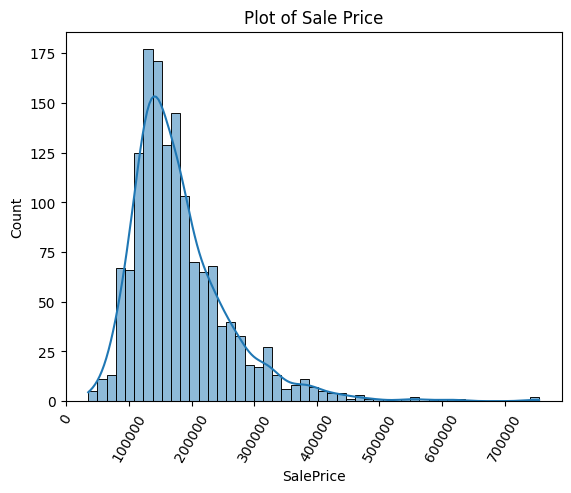

In [18]:
sns.histplot(train_data['SalePrice'], kde = True)
plt.xticks(rotation=60)
plt.title( "Plot of Sale Price")

print("Skewness: %f" % train_data['SalePrice'].skew())
print("Kurtosis: %f" % train_data['SalePrice'].kurt())

plt.show()

## Numerical Features

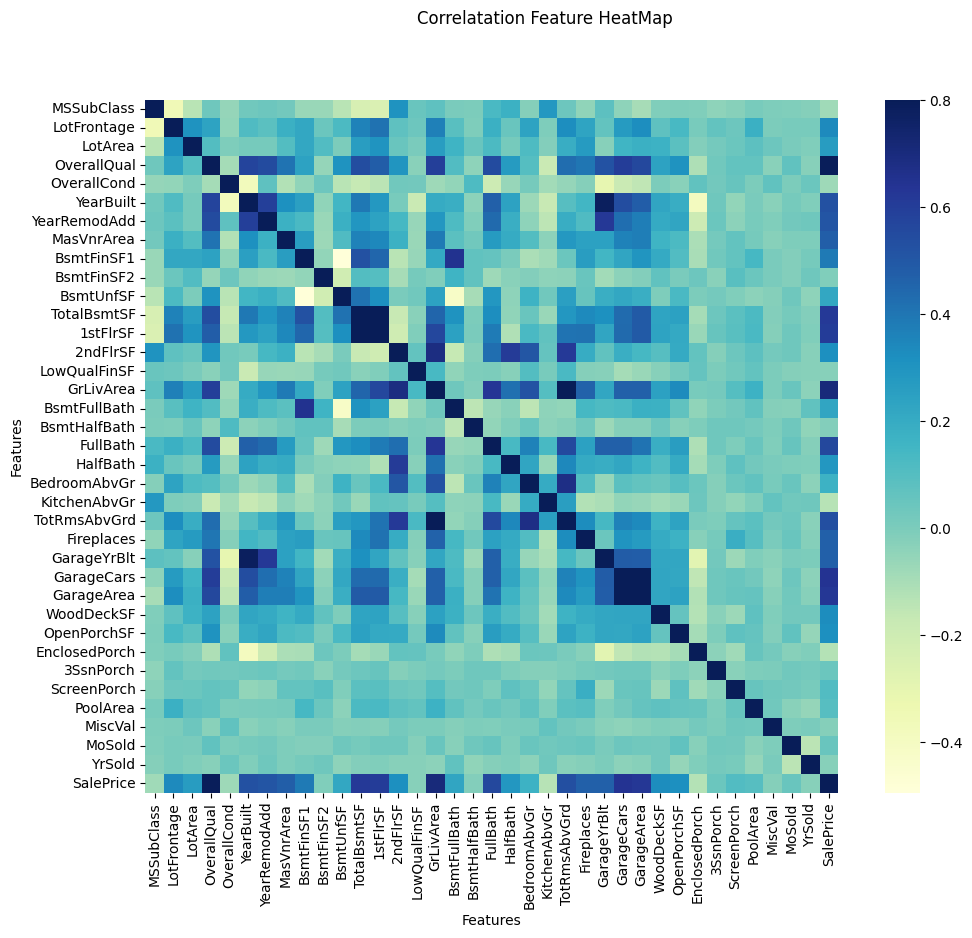

In [19]:
#correlation matrix
corr_mat = train_data.corr(numeric_only = True)
f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corr_mat, vmax=.8,square=True, cmap="YlGnBu")

plt.suptitle("Correlatation Feature HeatMap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

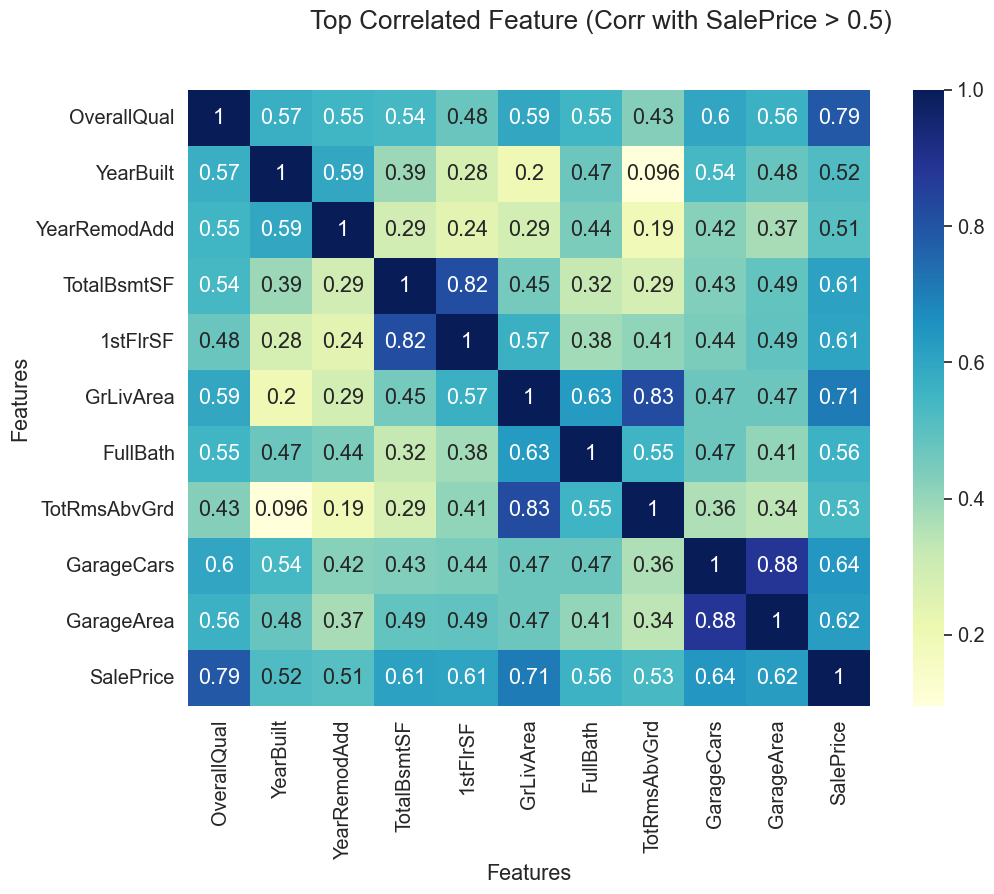

In [20]:
# most correlated features
corr_mat = train_data.corr(numeric_only = True)

sns.set(font_scale = 1.3)
plt.figure(figsize = (11,8))

top_corr = corr_mat.index[abs(corr_mat["SalePrice"])>0.5]
g = sns.heatmap(train_data[top_corr].corr(),annot=True,cmap="YlGnBu")
plt.suptitle("Top Correlated Feature (Corr with SalePrice > 0.5)")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

- OverallQual and GrLivArea appear to be the most correlated to SalePrice

In [21]:
print("Correlation Values")

corr = train_data.corr(numeric_only = True).drop('SalePrice')
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Correlation Values
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
GarageYrBlt      0.470177
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.334771
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


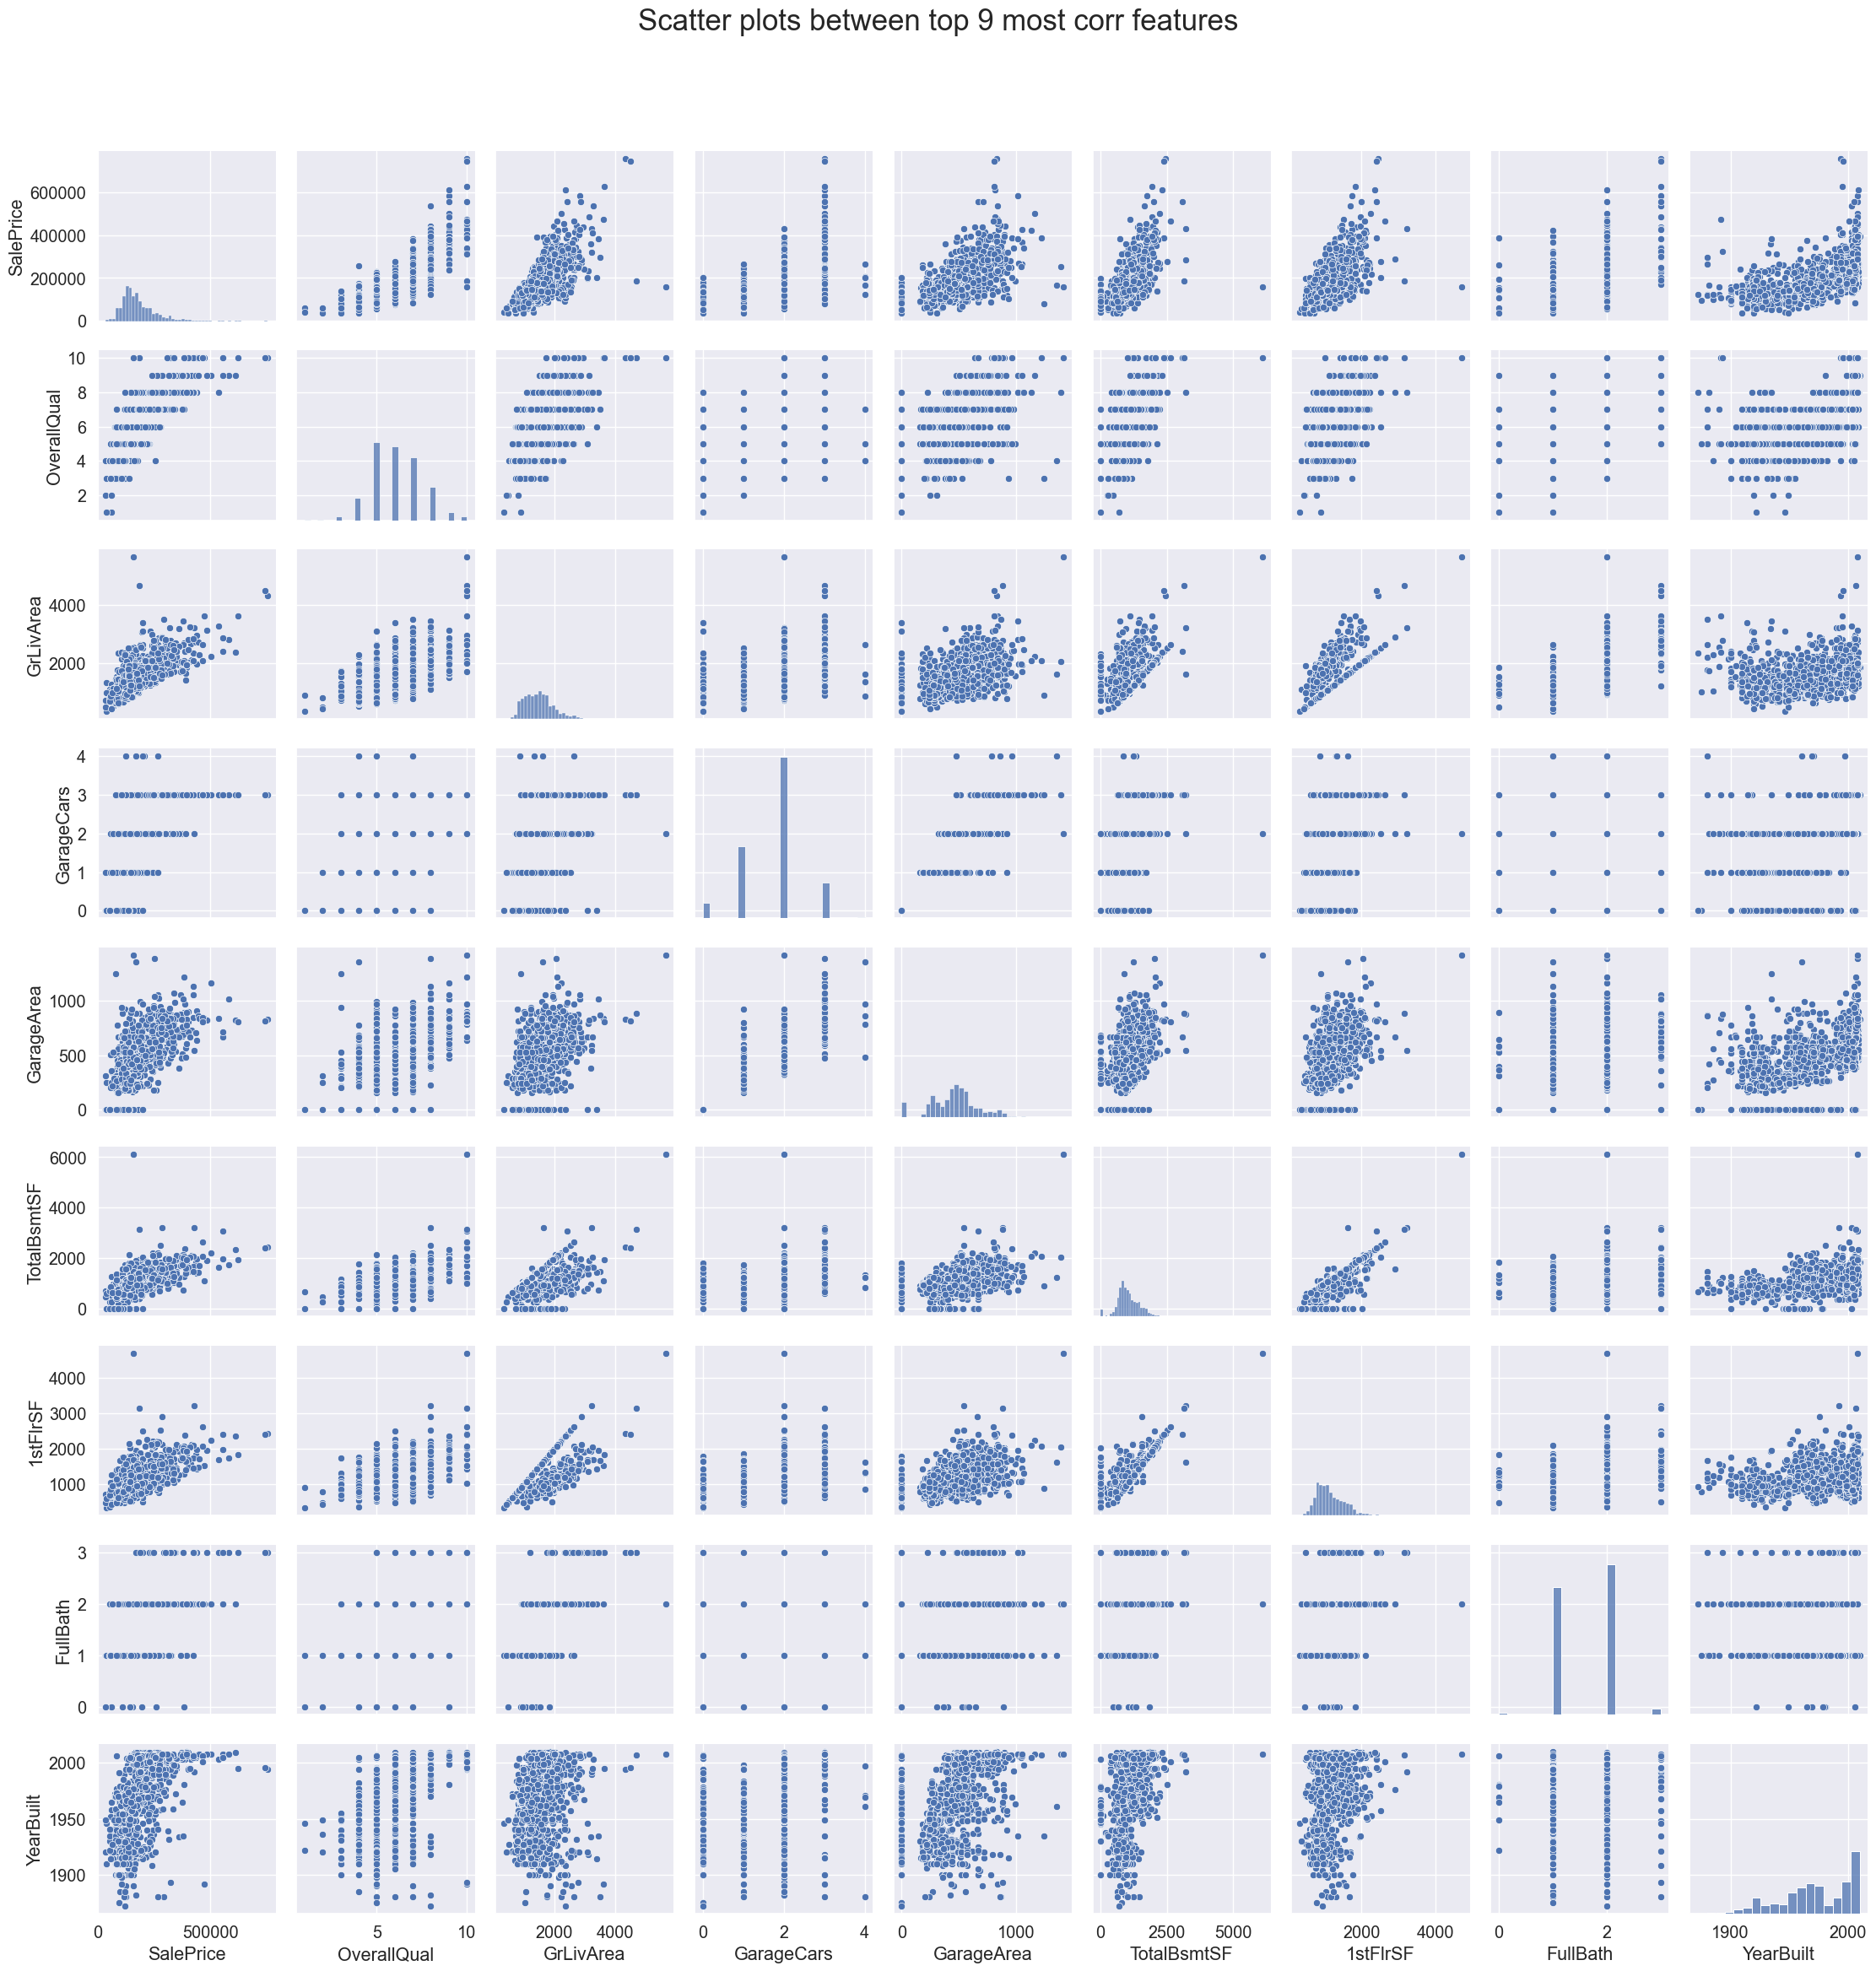

In [22]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars','GarageArea', 'TotalBsmtSF','1stFlrSF','FullBath','YearBuilt']
sns_plot = sns.pairplot(train_data[cols])

plt.suptitle('Scatter plots between top 9 most corr features', y=1.04, size=25)
plt.tight_layout()
plt.show()

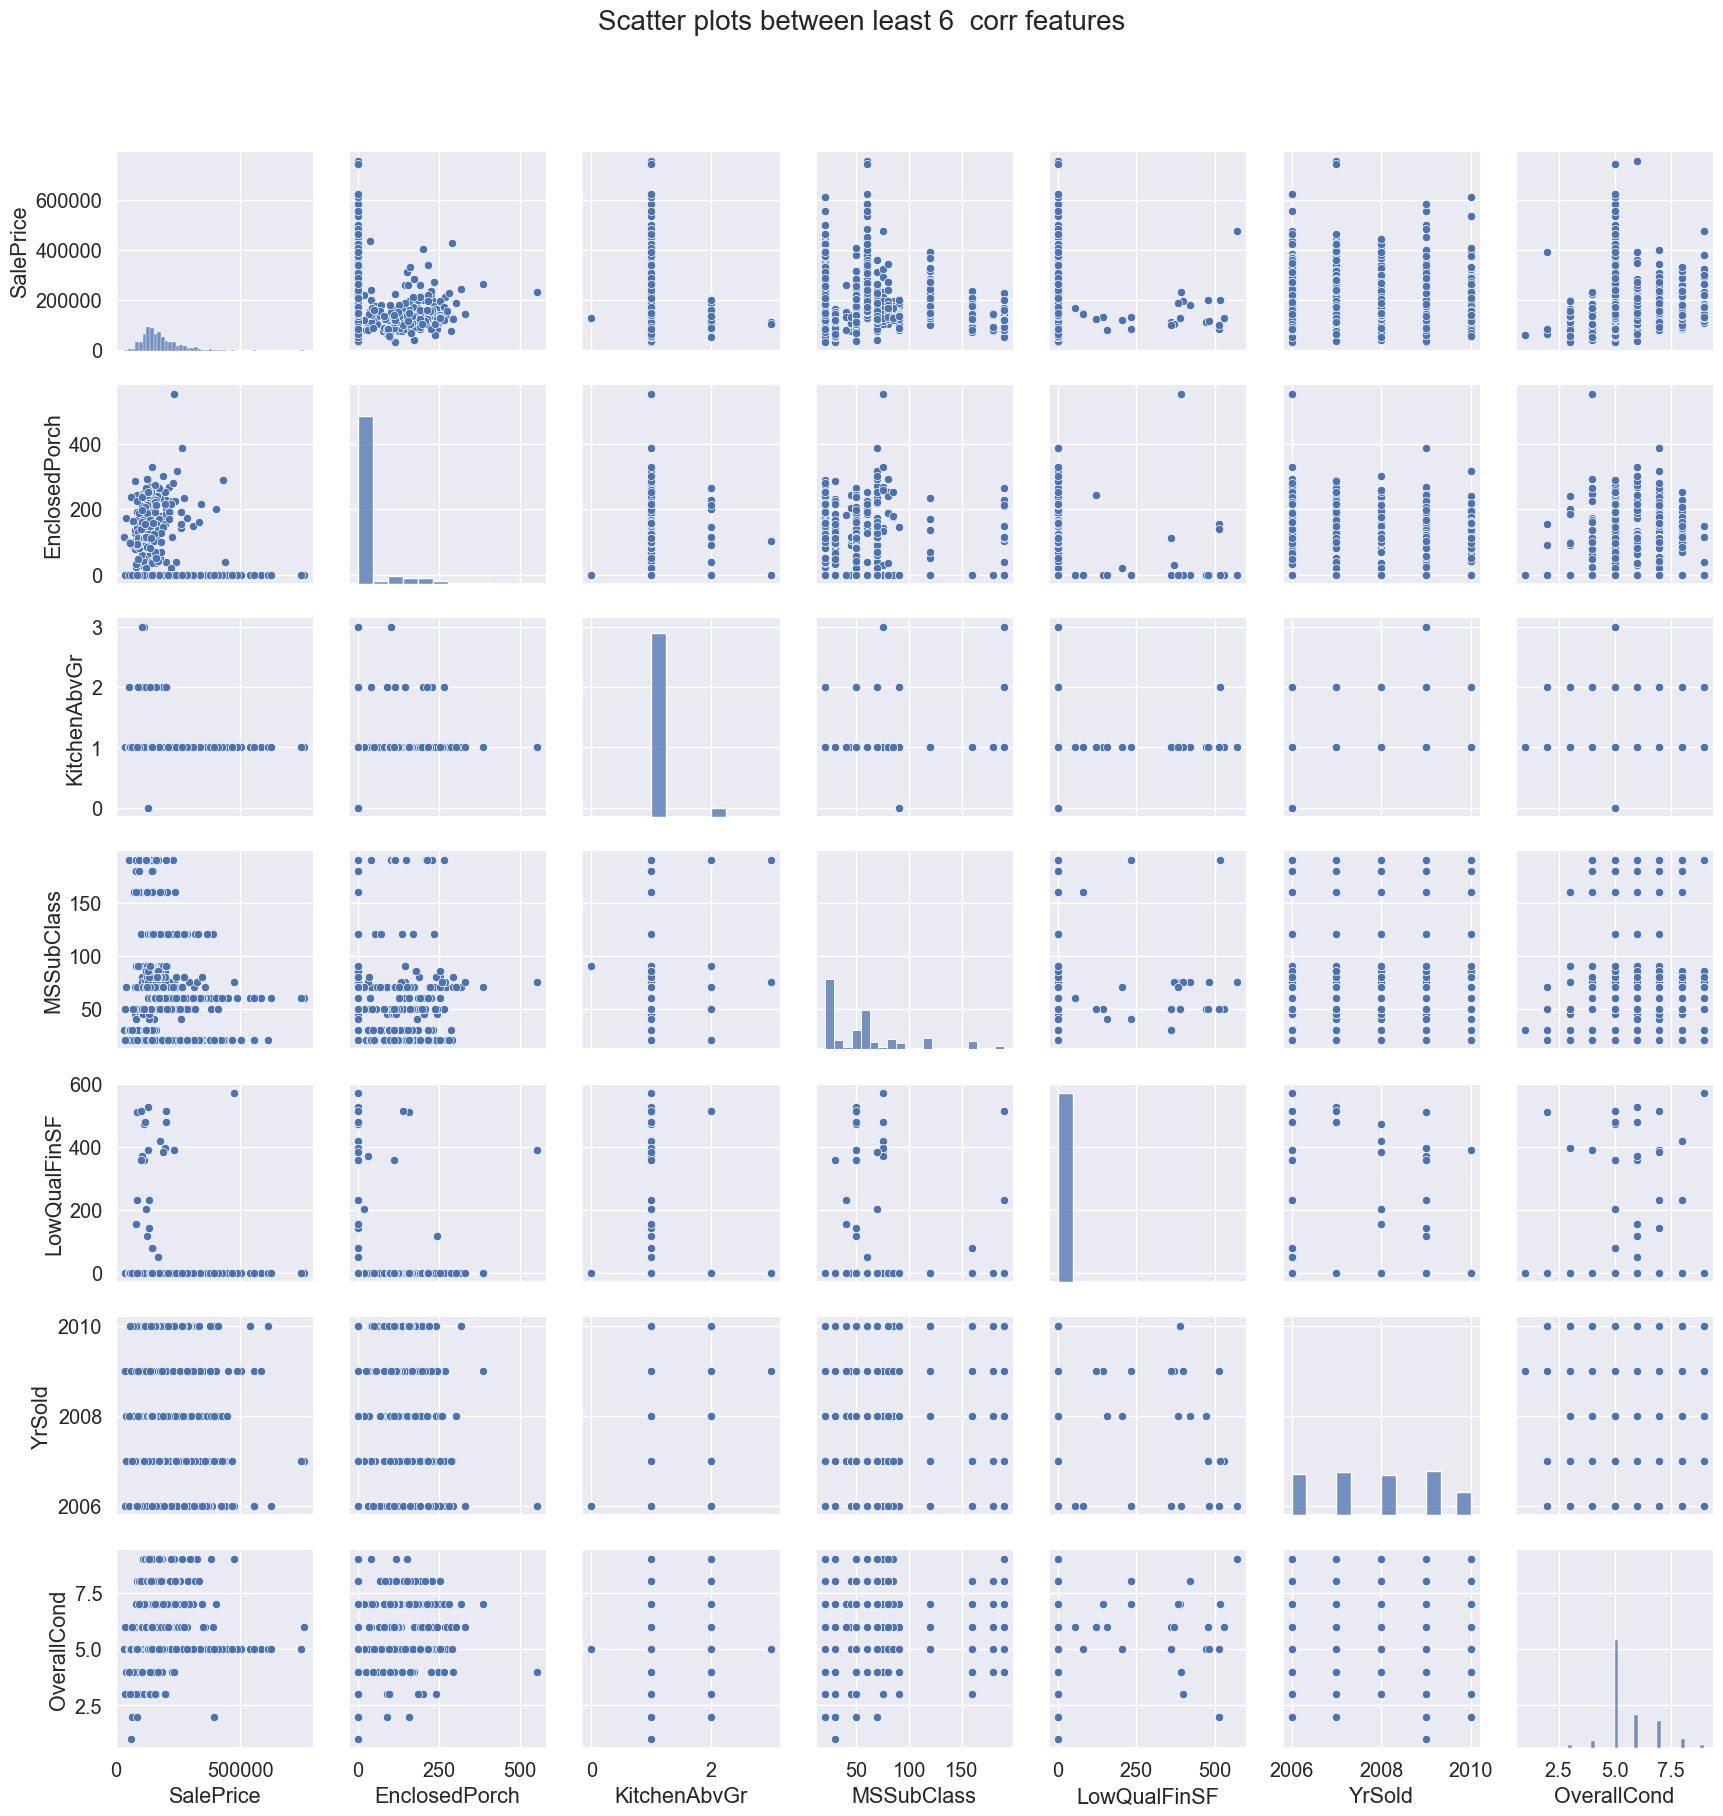

In [23]:
cols = ['SalePrice','EnclosedPorch', 'KitchenAbvGr', 'MSSubClass', 'LowQualFinSF','YrSold', 'OverallCond']
sns_plot = sns.pairplot(train_data[cols])

plt.suptitle('Scatter plots between least 6  corr features', y=1.04, size=20)
plt.tight_layout()
plt.show()

In [24]:
#function to plot scatter plot between a feature and the Sale Price 
def scatter_plot(a):
    plt.figure(figsize=(6,6))
    plt.scatter(x = train_data[a], y = train_data['SalePrice'], edgecolor="black")
    plt.ylabel('SalePrice')
    plt.xlabel(a)
    plt.title("Scatter Plot of "+ a + " and SalePrice")
    plt.show()

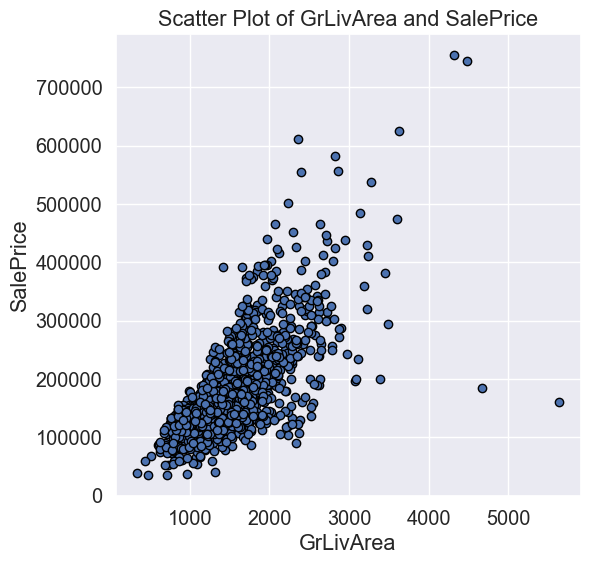

In [25]:
scatter_plot('GrLivArea')

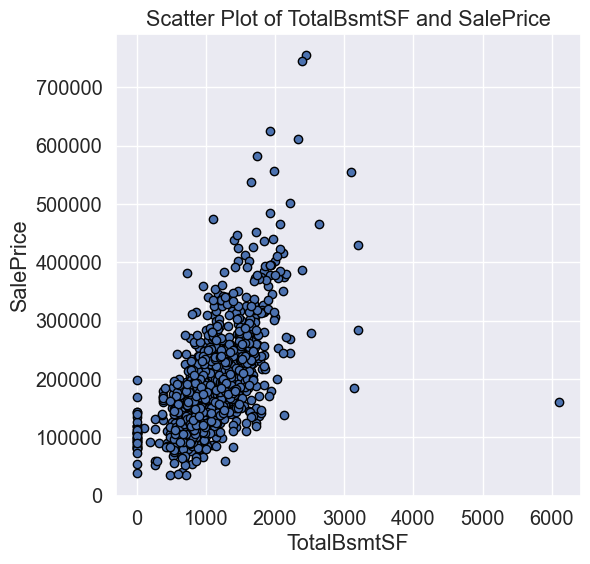

In [26]:
scatter_plot('TotalBsmtSF')

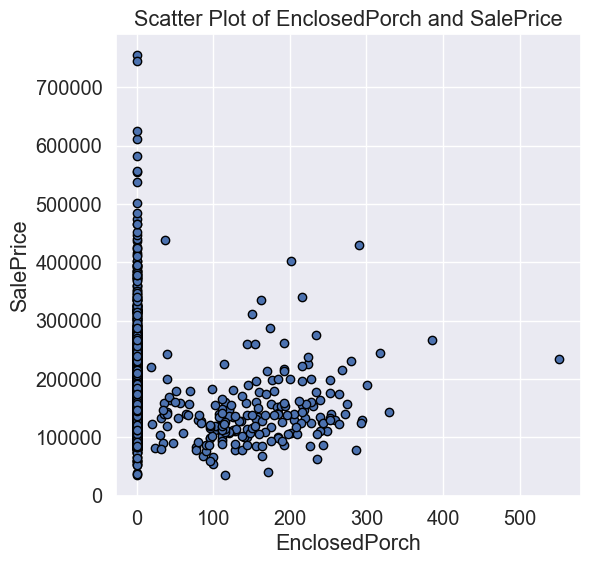

In [27]:
scatter_plot('EnclosedPorch')

## Categorical Features

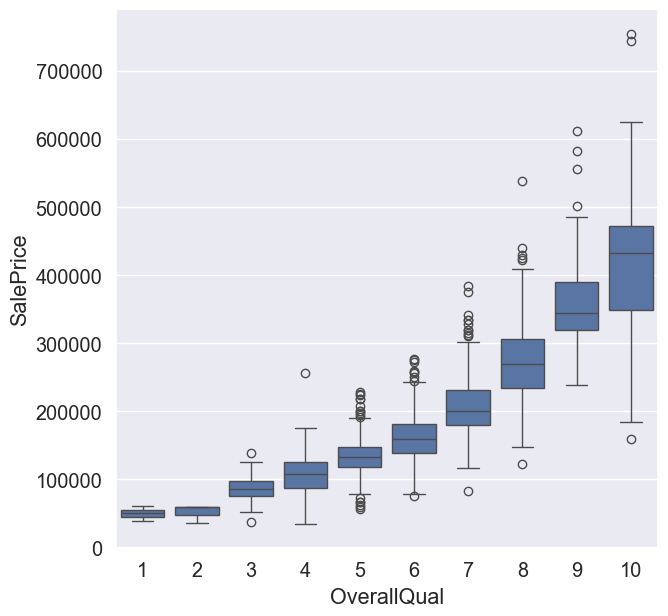

In [28]:
# plot a box plot for categorical feature : Overall Quality

fig = plt.figure(figsize=(7,7))
data = pd.concat([train_data['SalePrice'], train_data['OverallQual']], axis=1)
sns.boxplot(x = train_data['OverallQual'], y="SalePrice", data = data)
plt.show()

Dropping Columns with more than 95% data contained in a categorical column is in one category. This is done because these columns have very low variability

In [29]:
# Threshold for dropping columns (95%)
threshold = 0.95
cols = []

for column in train_data.columns:
    normalized_counts = train_data[column].value_counts(normalize=True)
    if normalized_counts.iloc[0] > threshold:
        cols.append(column)

In [30]:
train_data.drop(columns = cols, inplace=True)
test_data.drop(columns = cols, inplace=True)

print("Shape of the dataframe after dropping Low variability categorical columns")
print("Training dataset shape:", train_data.shape)
print("Test dataset shape:", test_data.shape)

Shape of the dataframe after dropping Low variability categorical columns
Training dataset shape: (1460, 65)
Test dataset shape: (1459, 64)


In [31]:
cat_cols = []
num_cols = []

unique_count = train_data.nunique()
for col in train_data.columns:
    if unique_count[col] <= 25:
        cat_cols.append(col)
    else:
        num_cols.append(col)

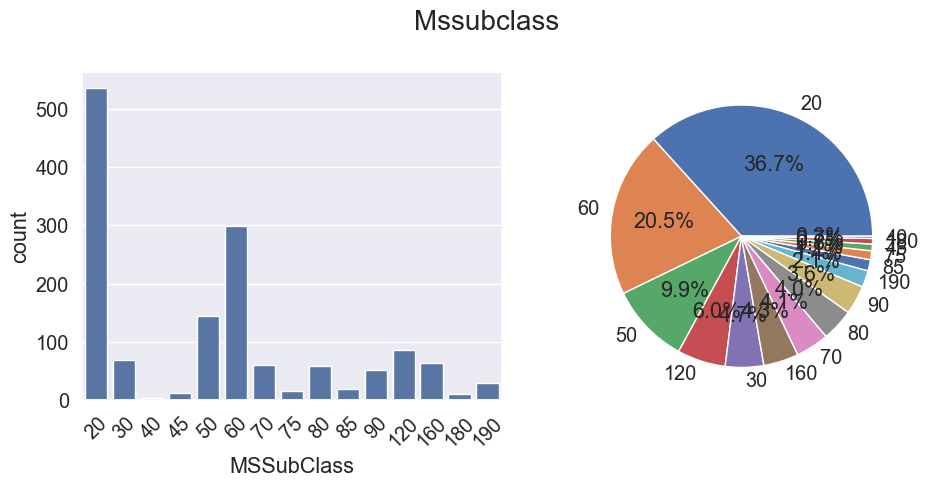

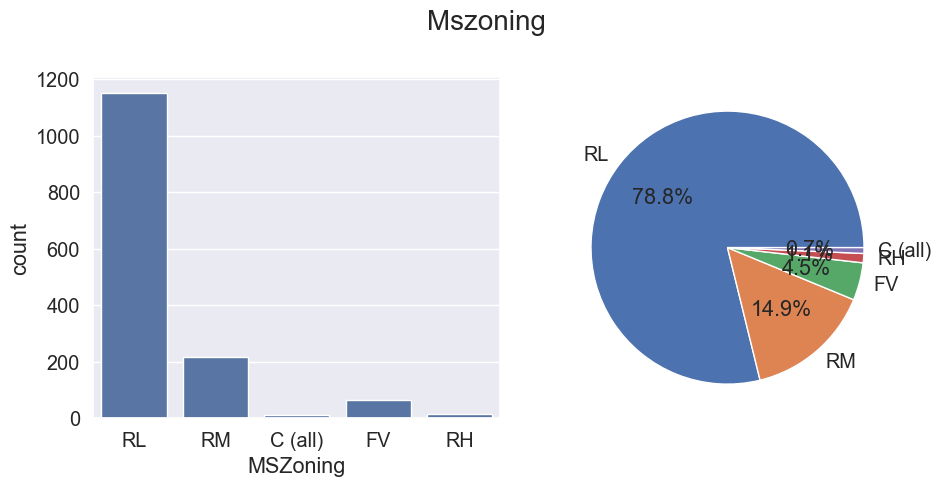

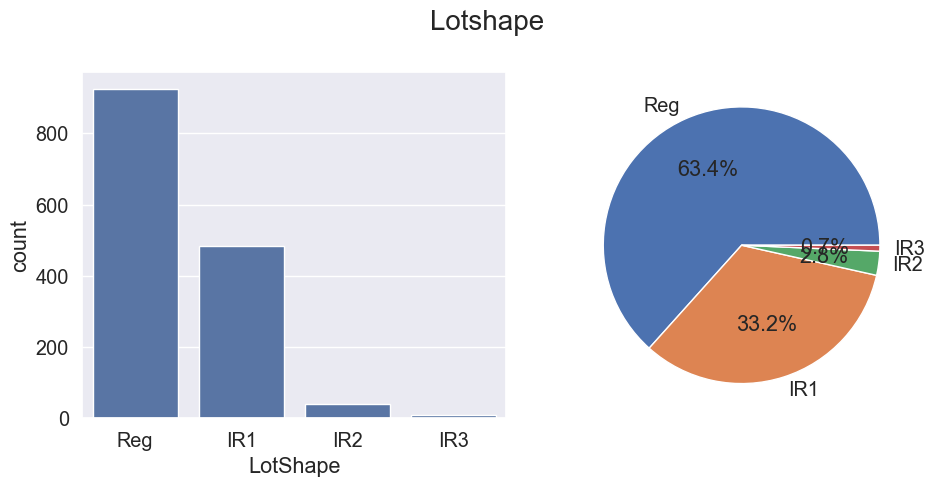

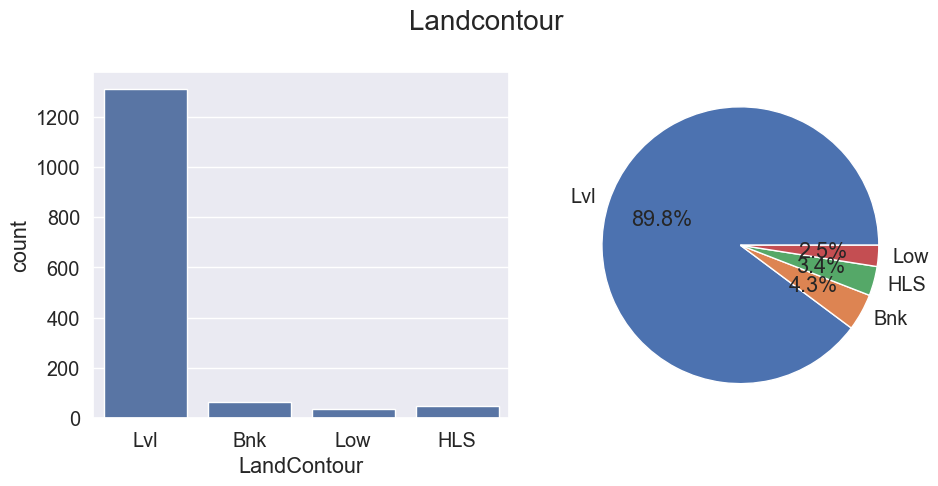

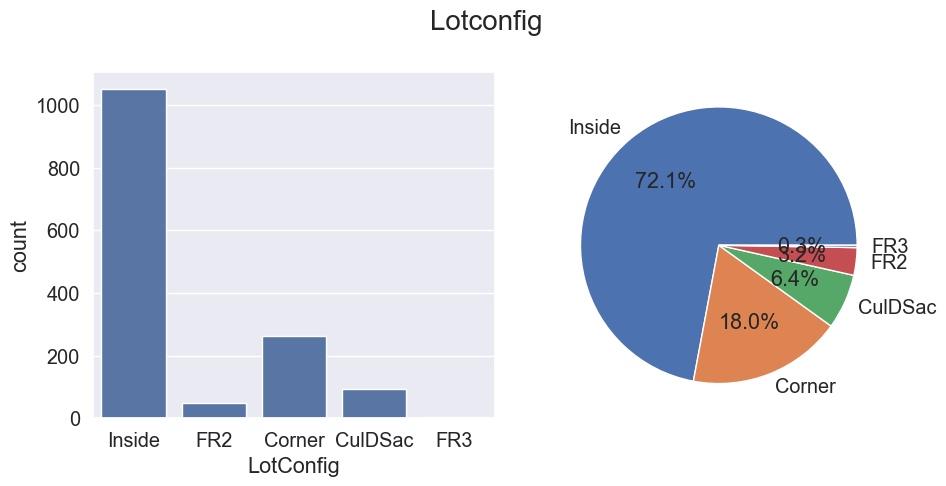

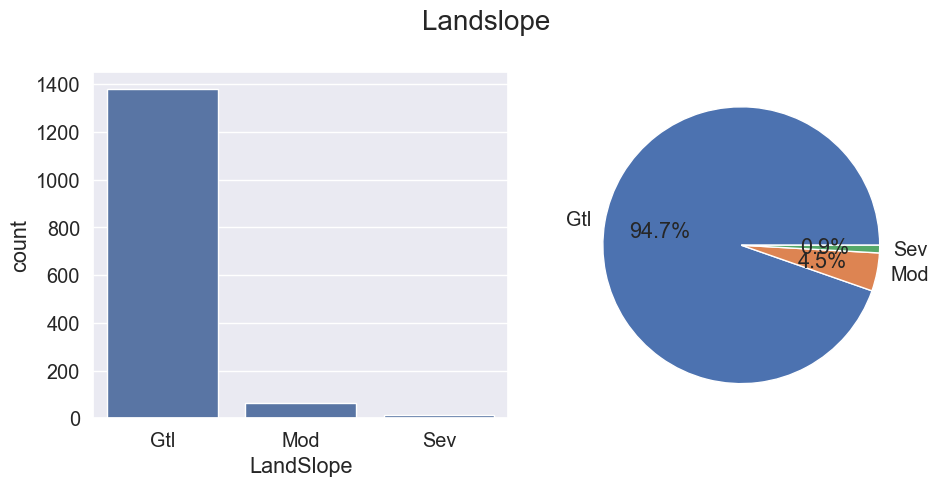

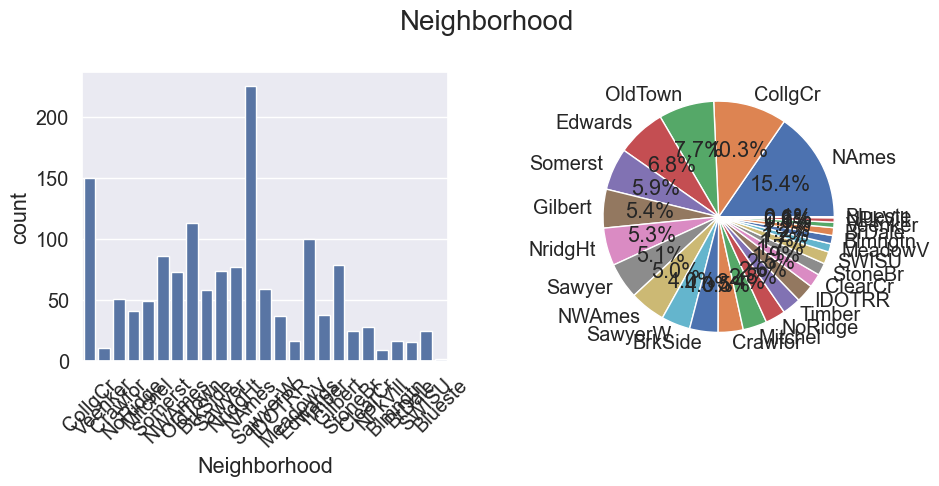

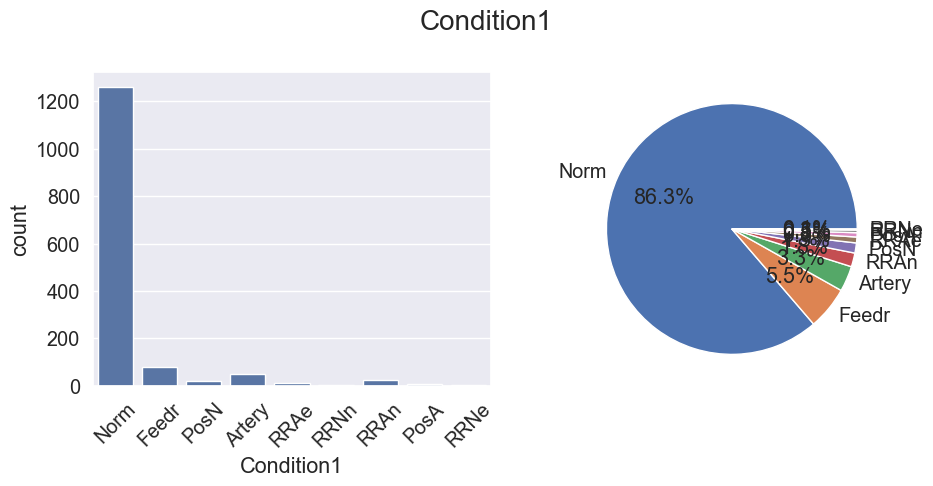

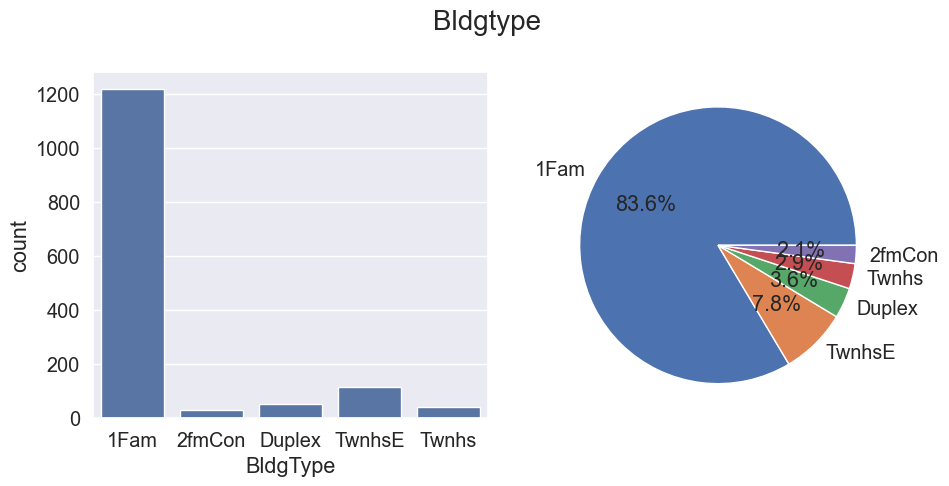

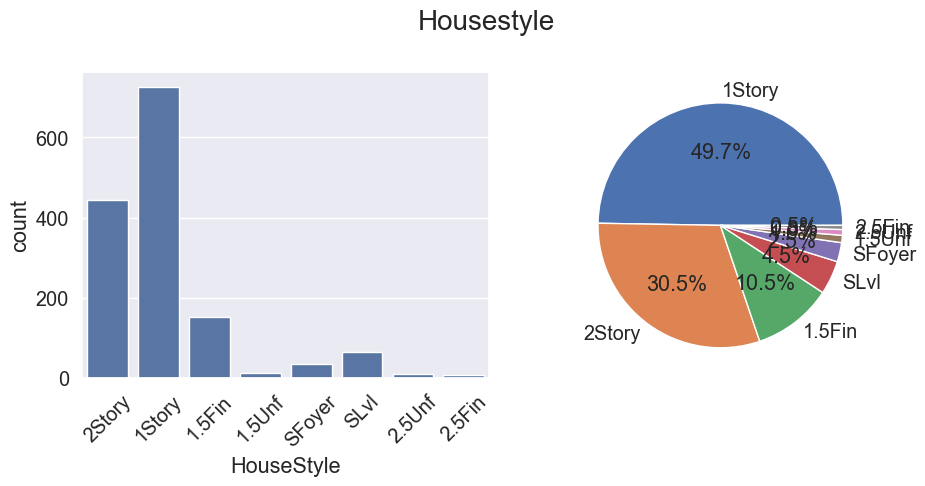

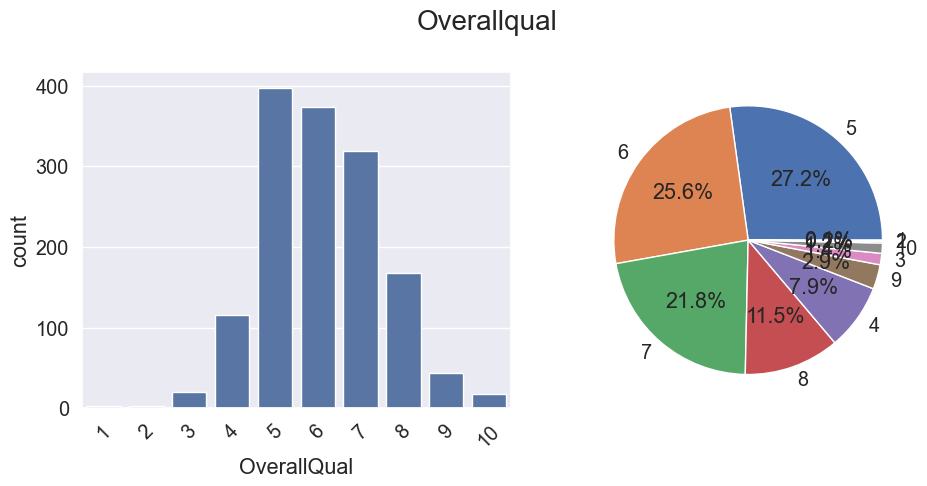

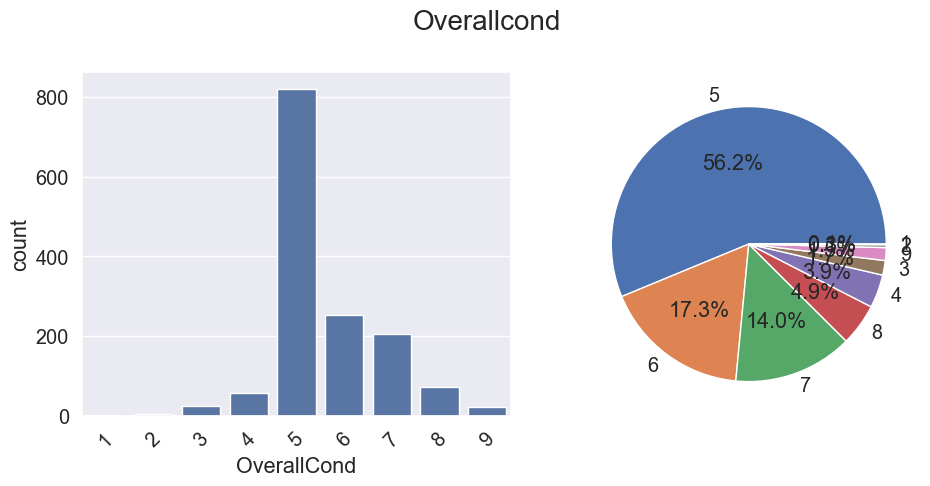

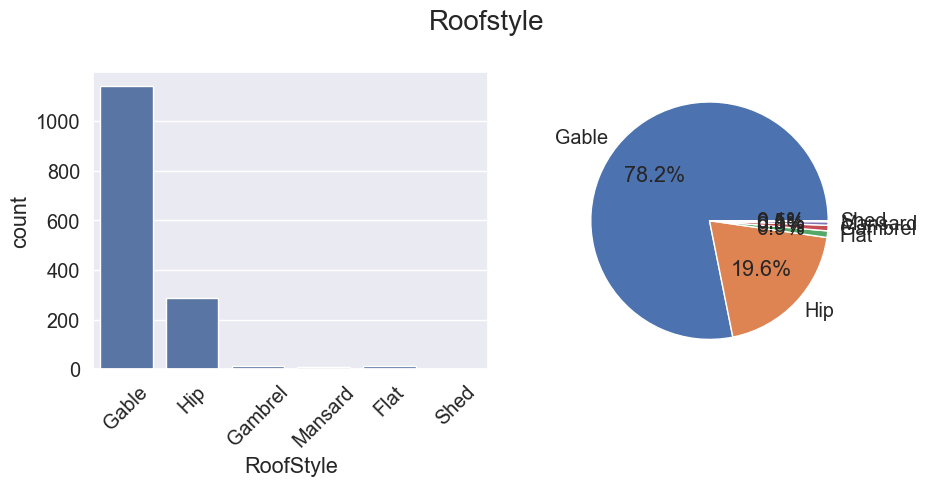

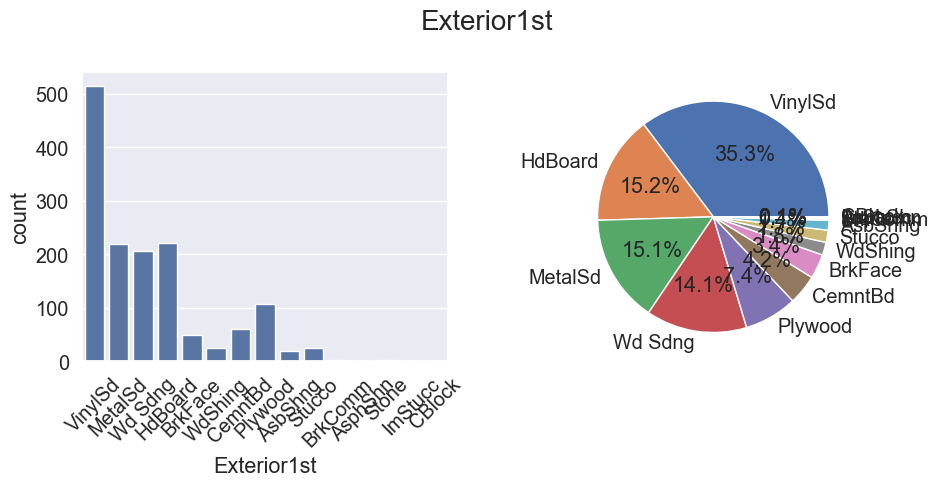

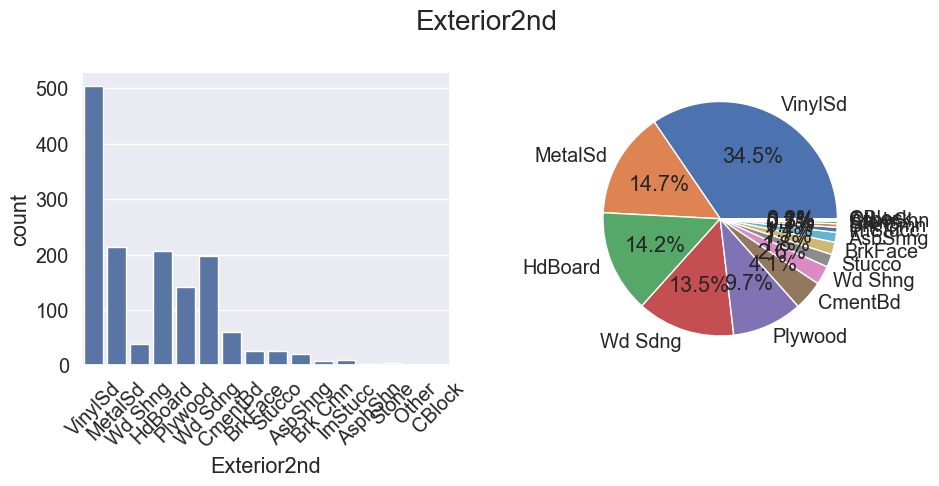

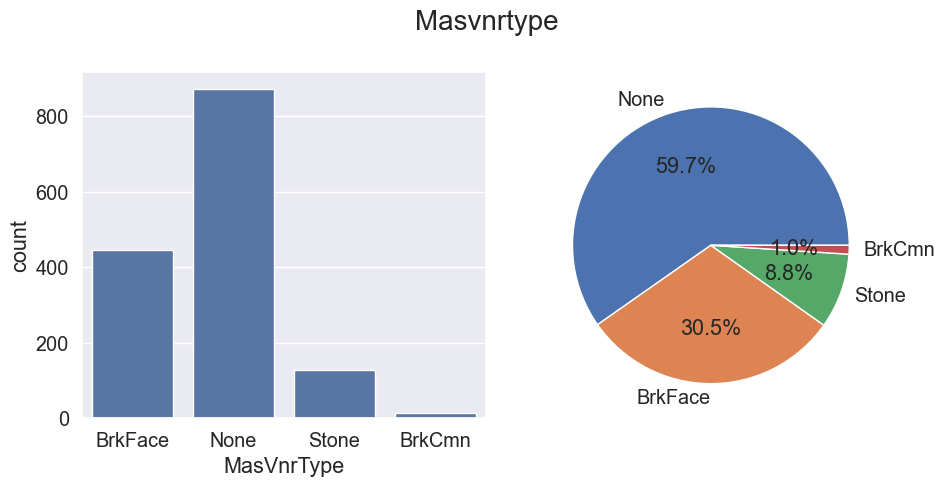

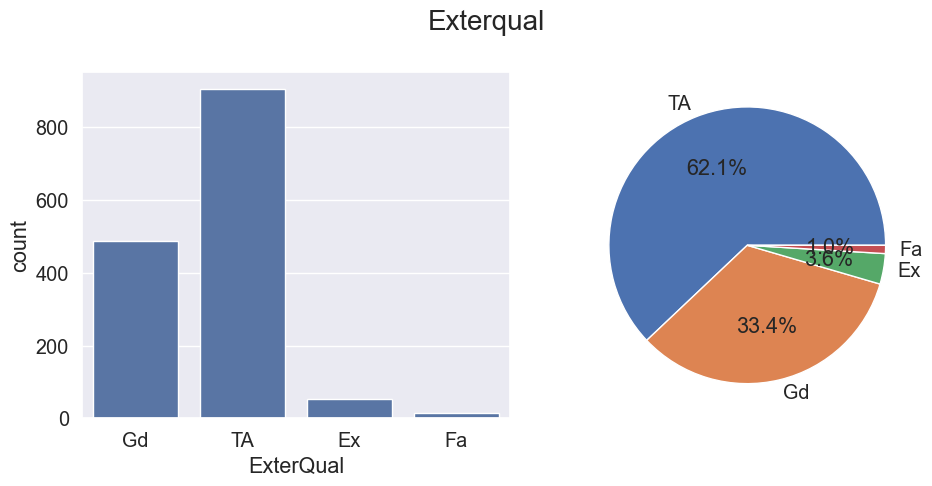

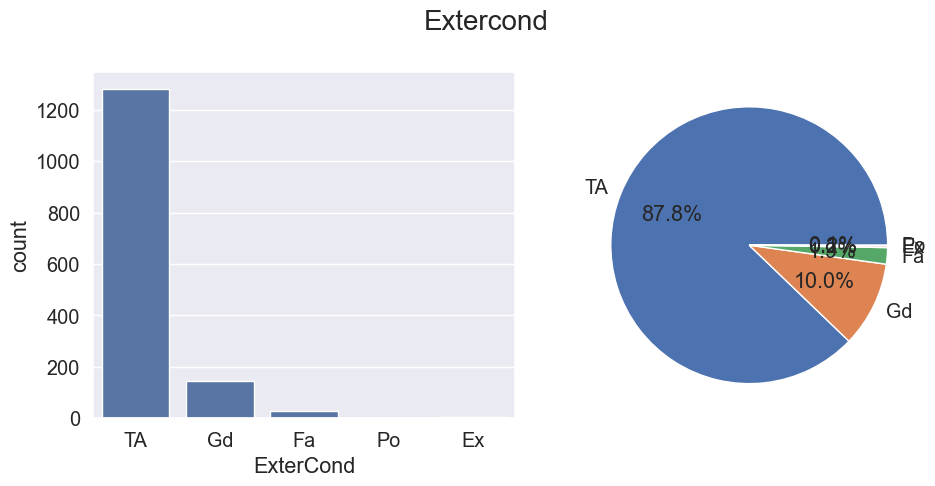

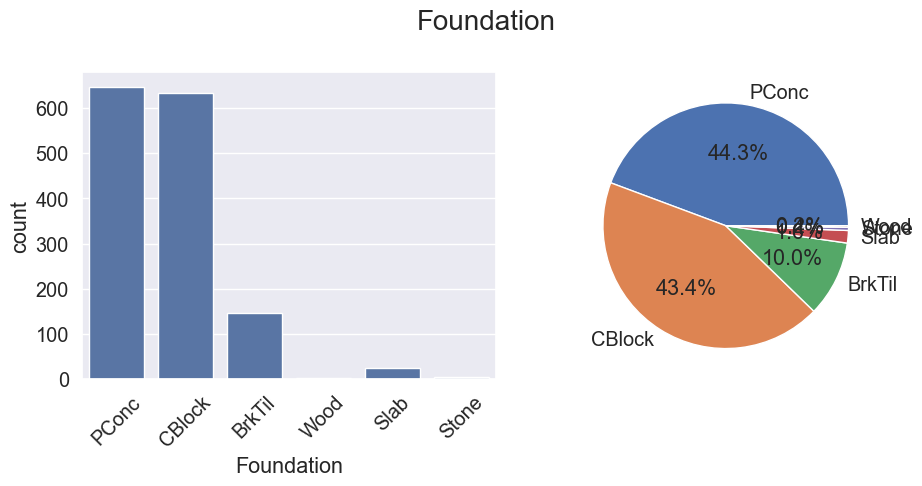

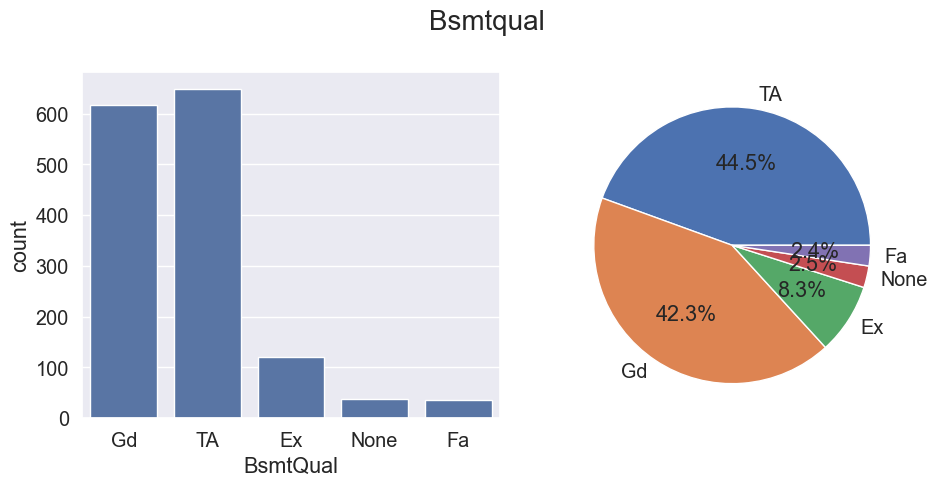

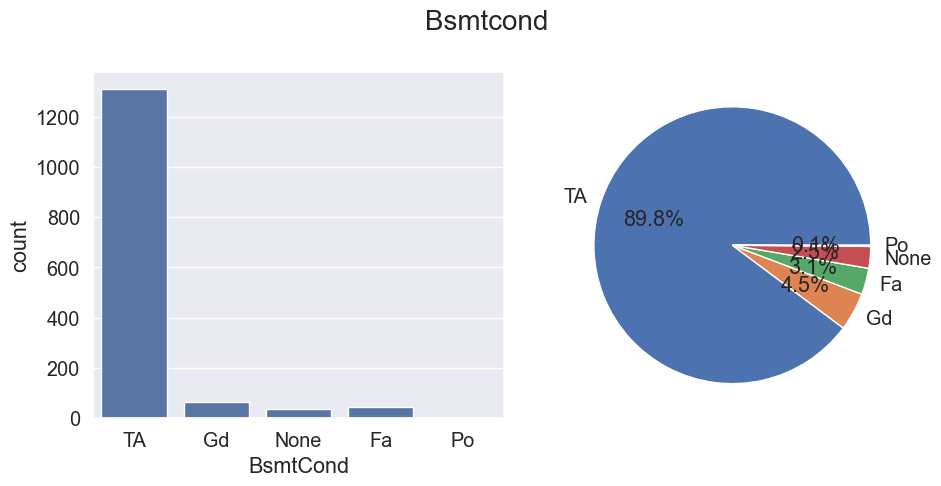

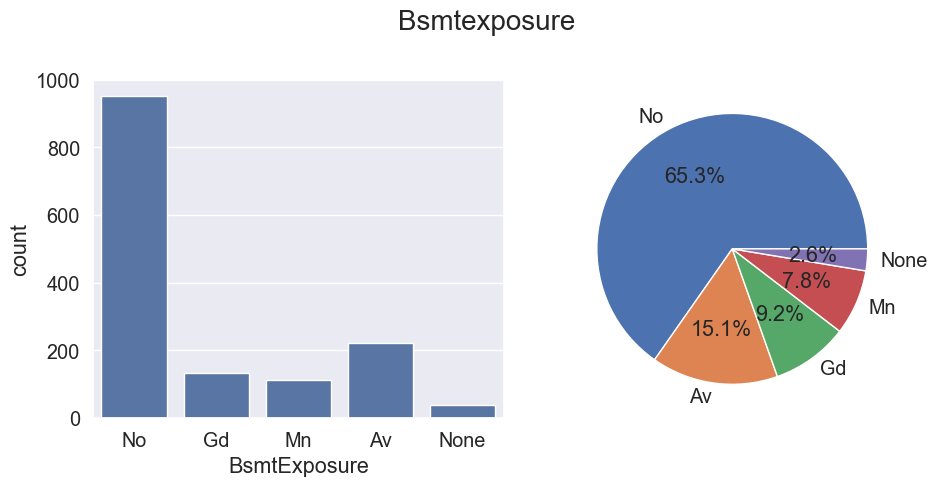

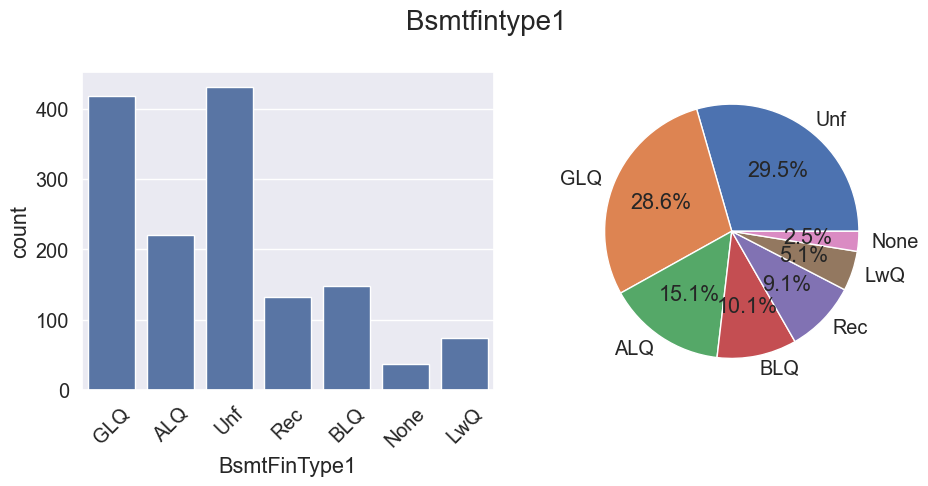

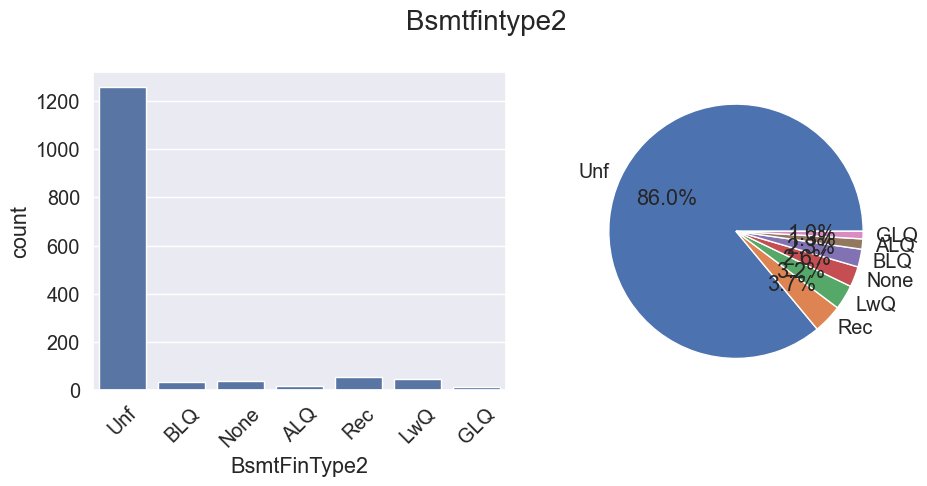

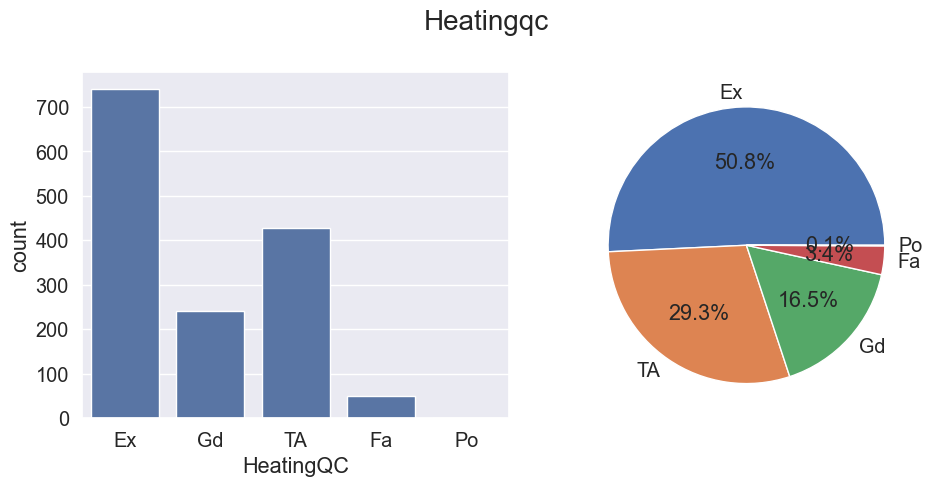

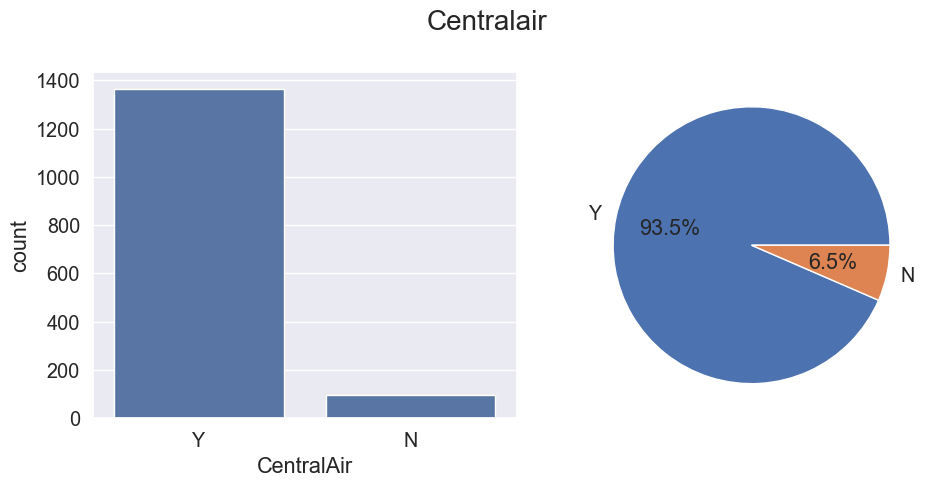

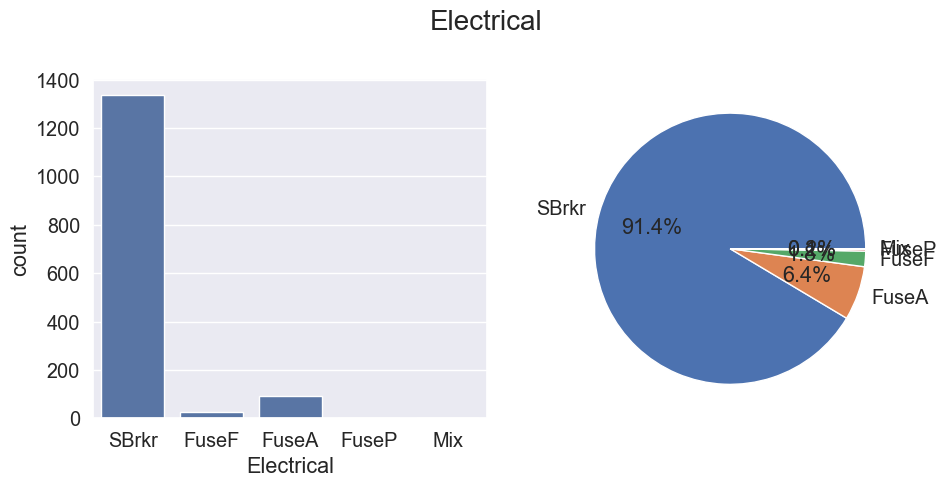

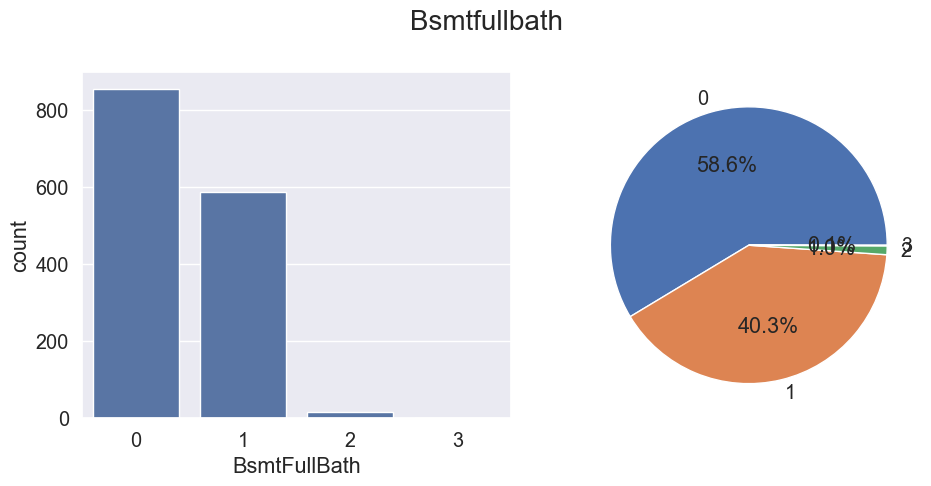

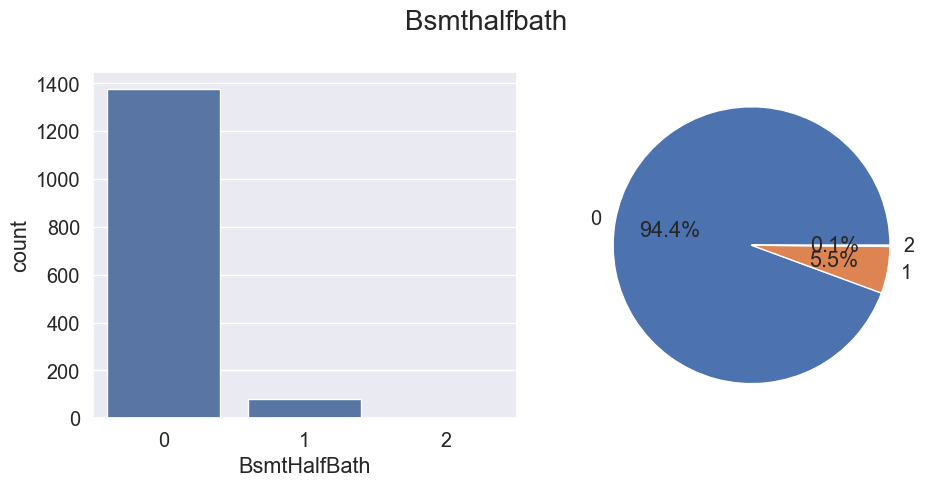

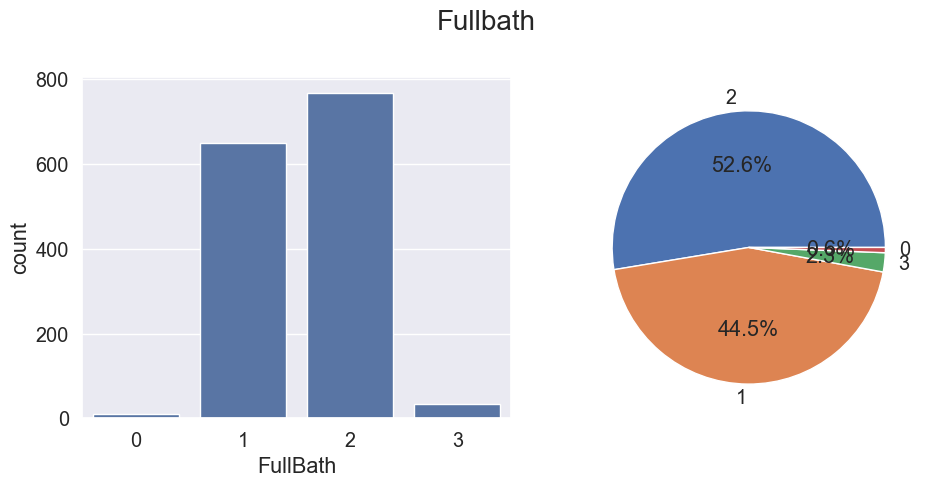

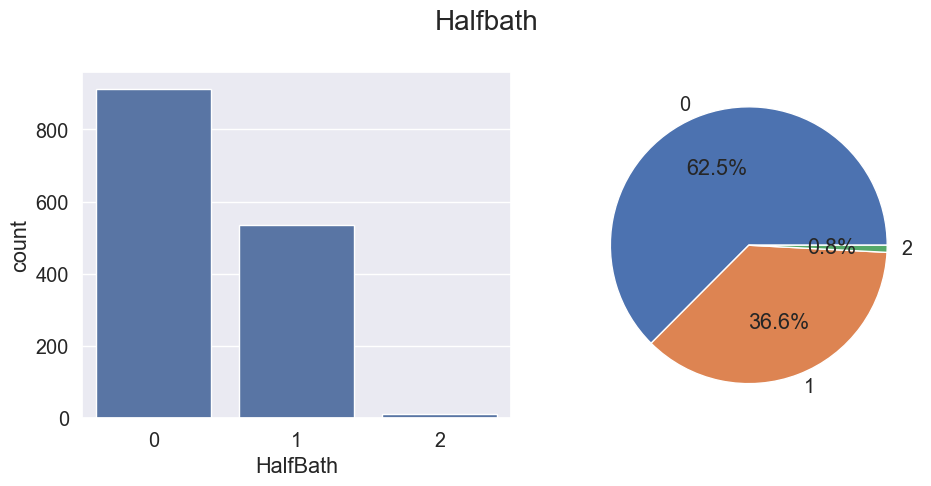

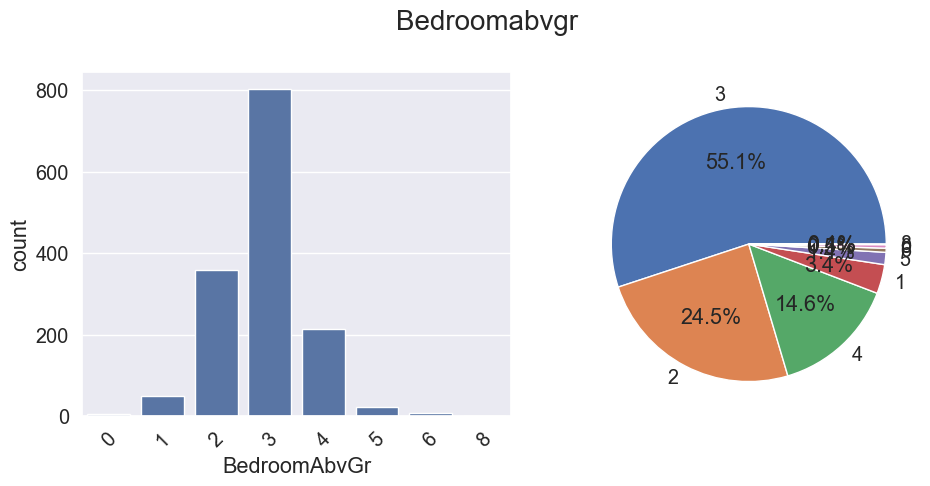

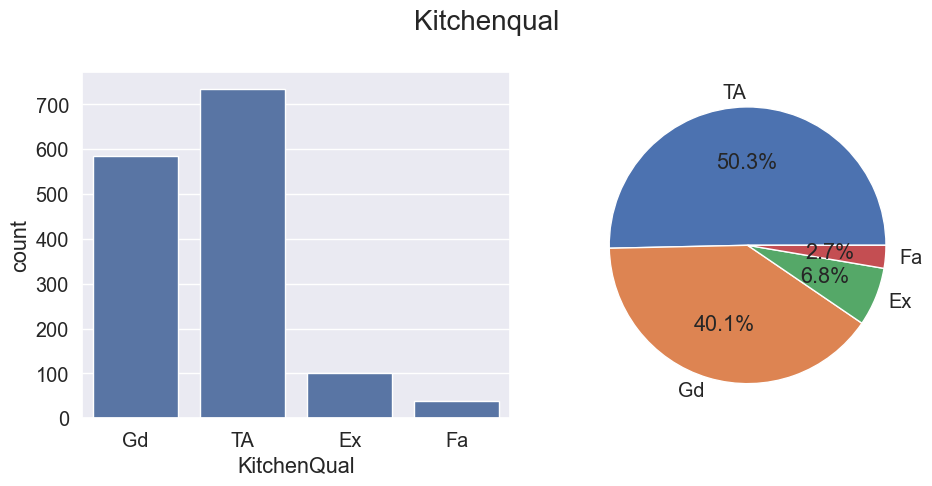

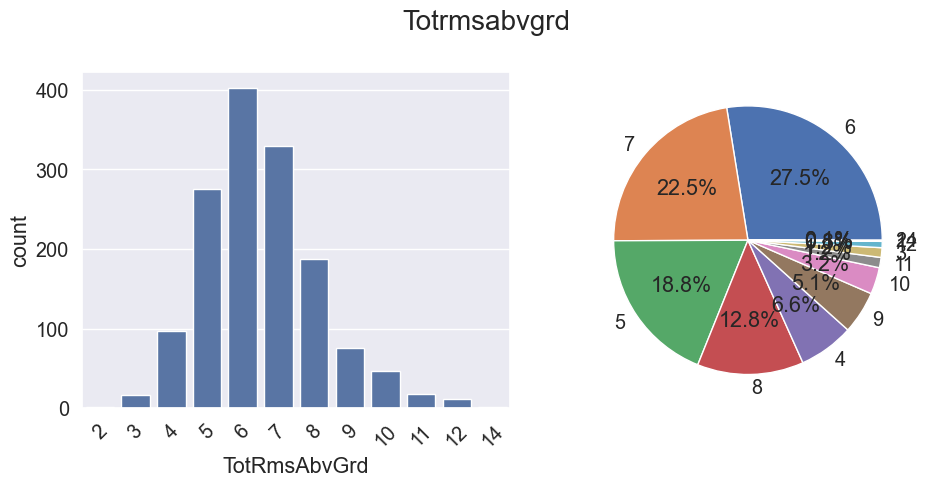

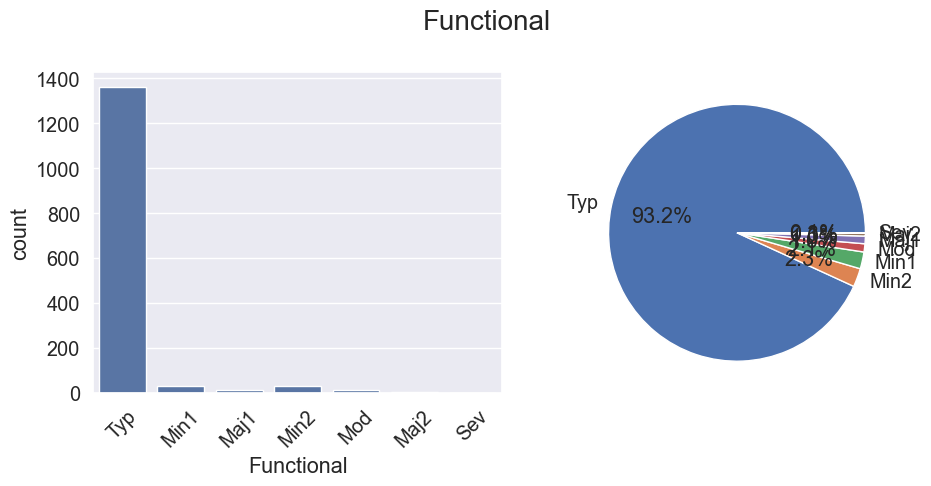

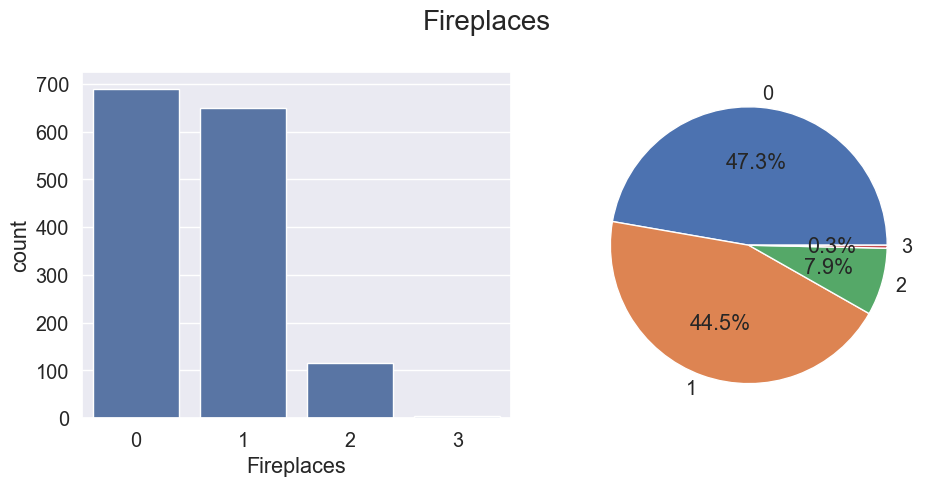

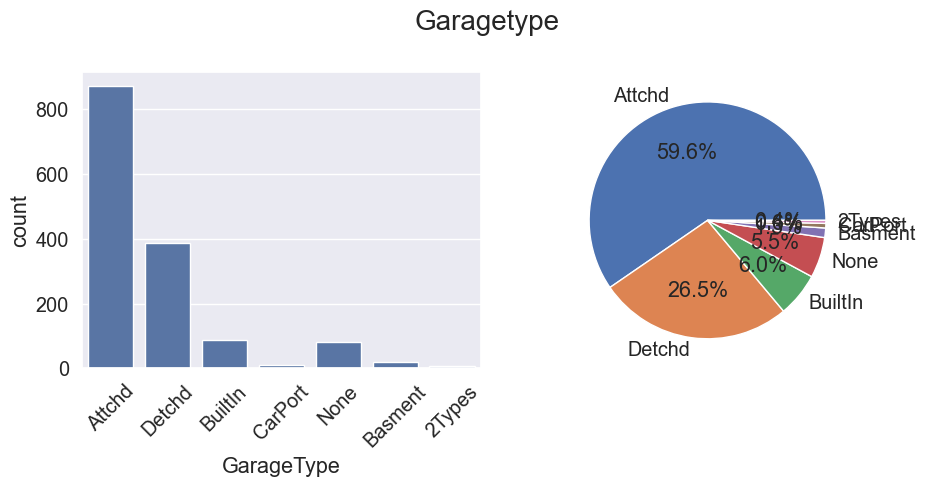

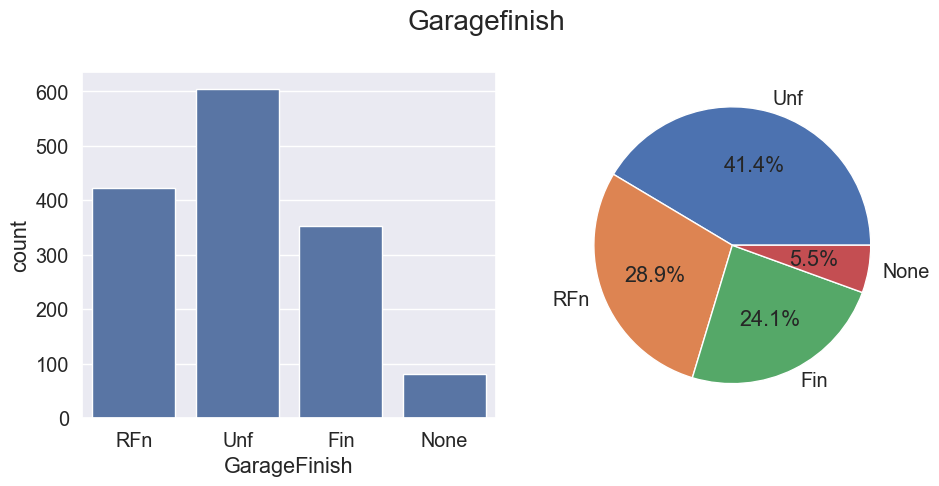

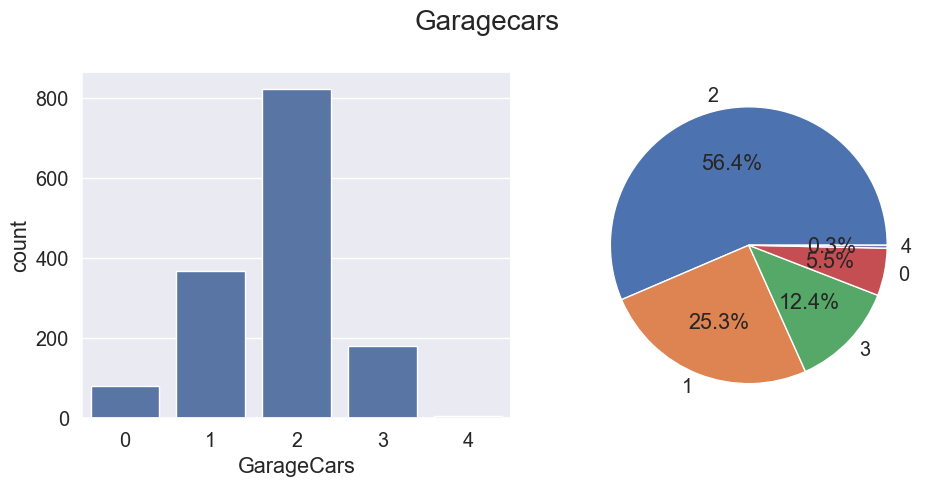

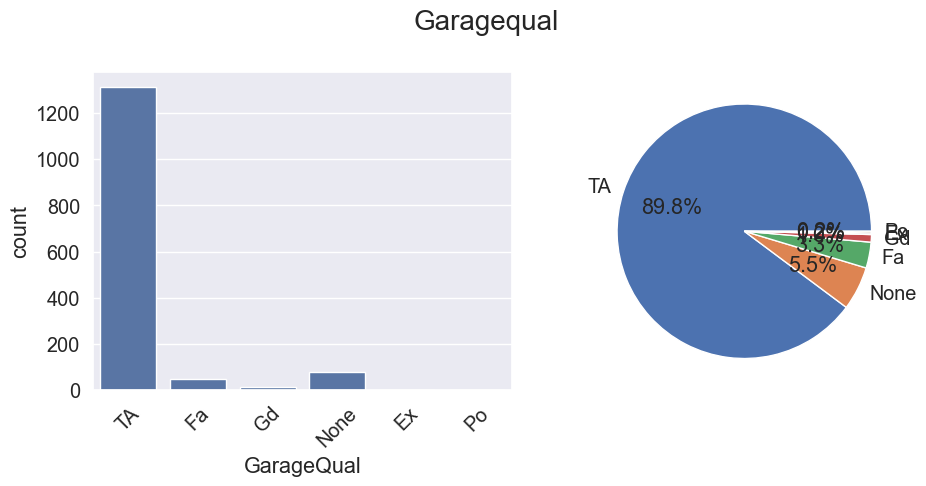

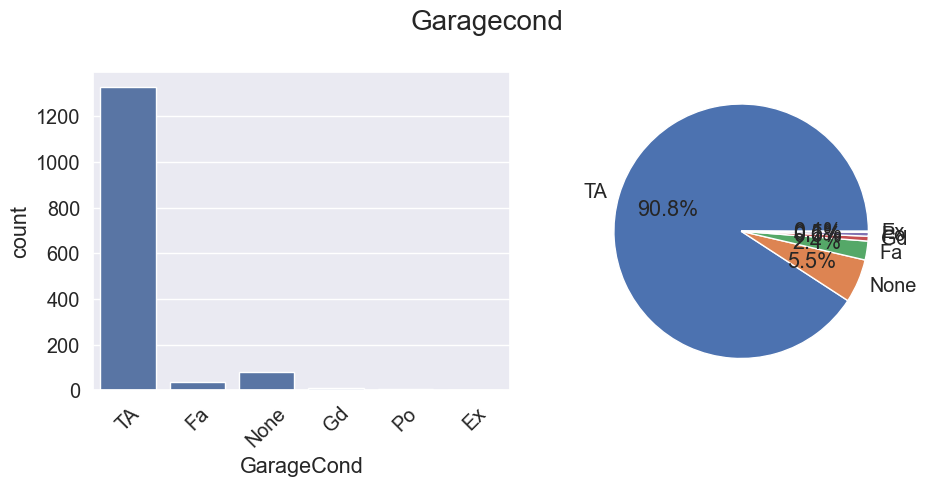

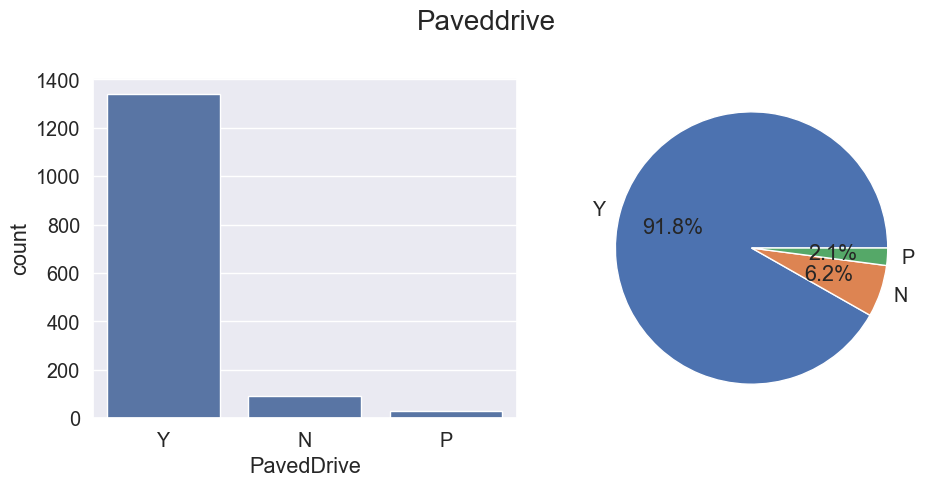

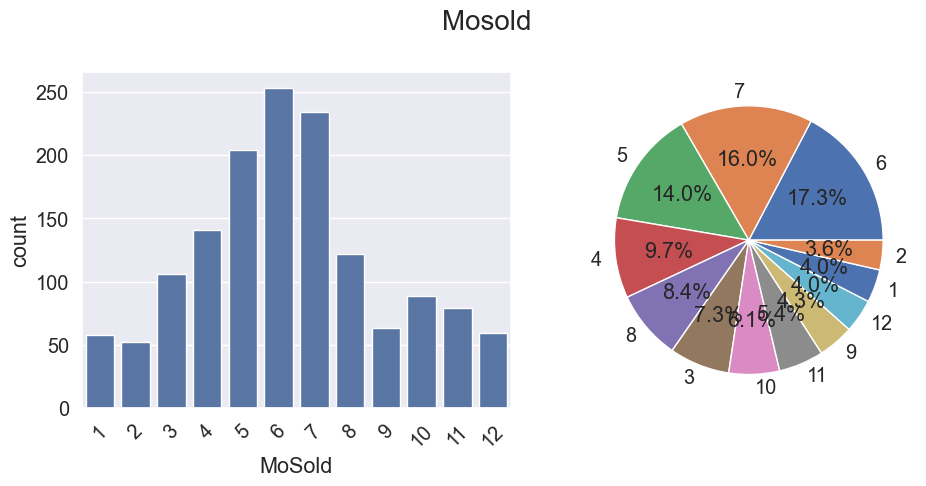

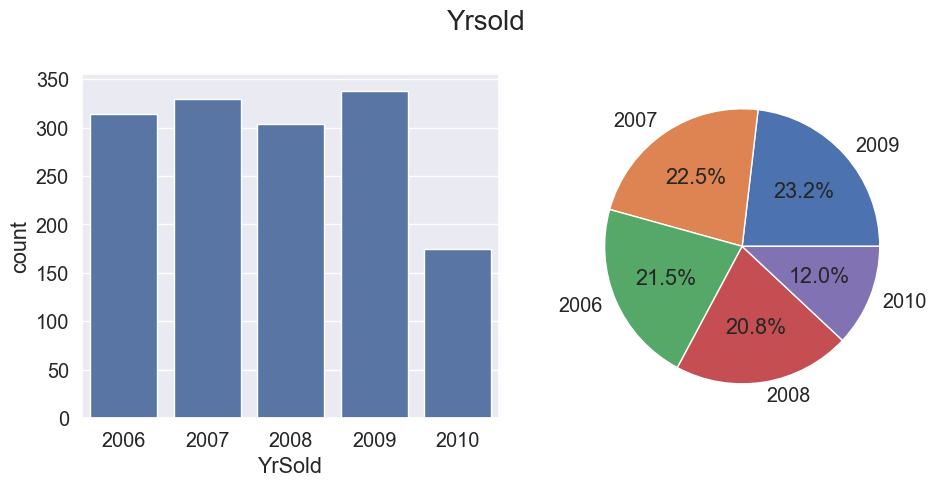

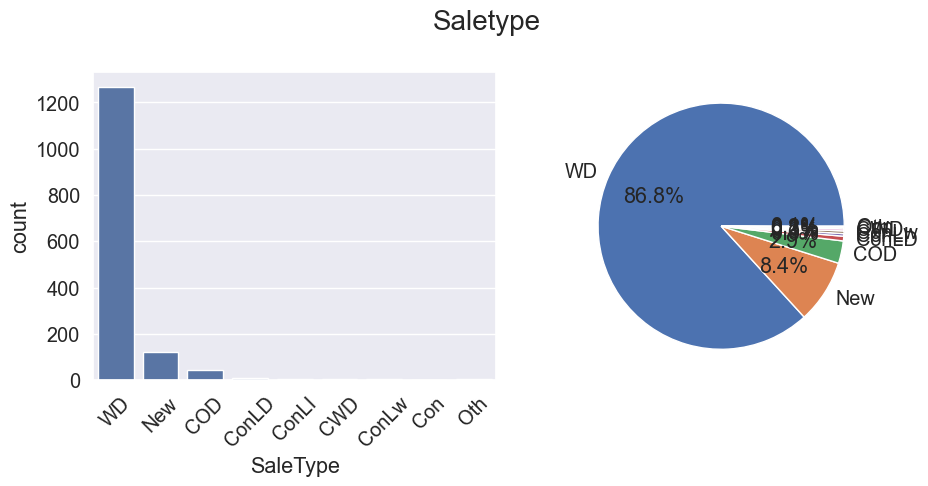

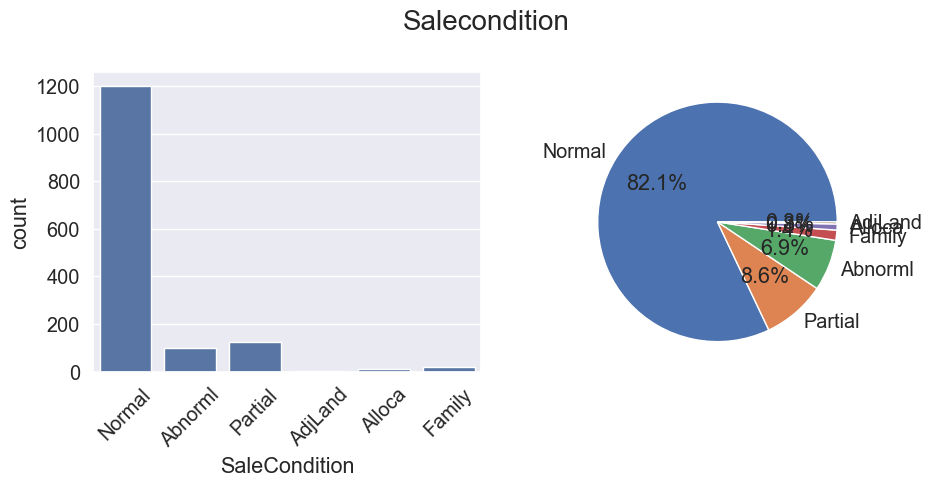

In [32]:
def uni_cat_cols(df, cat_cols):
    """
    Input : Dataframe and Categorical columns list
    Output: Displays univariate graphs of categorical columns
    """
    for col in cat_cols:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Bargraphs for category distributions
        plt.subplot(1, 2, 1)
        if len(df[col].unique()) > 5:
            sns.countplot(data=df, x=col, ax=axes[0])
            plt.xticks(rotation=45)  # Rotate x-axis labels if more than 5 categories
        else:
            sns.countplot(data=df, x=col, ax=axes[0])

        # Piecharts for category distributions
        plt.subplot(1, 2, 2)
        df[col].value_counts().plot.pie(ax=axes[1], autopct='%1.1f%%')
        plt.ylabel("")

        fig.suptitle(col.capitalize(), fontsize=20)
        plt.tight_layout()

        plt.show()

uni_cat_cols(train_data, cat_cols)

# Data Preprocessing

In [33]:
# Saving the SalePrice Column as target and dropping it
y_train = train_data.SalePrice
train_data.drop("SalePrice", axis = 1, inplace=True)

## One-hot Encoding

In [34]:
# Create dummy variables for categorical columns with drop_first=True
train_data_dummies = pd.get_dummies(train_data[cat_cols], drop_first=True)
test_data_dummies = pd.get_dummies(test_data[cat_cols], drop_first=True)

# Align the columns to ensure consistency between training and test datasets
train_data_dummies, test_data_dummies = train_data_dummies.align(test_data_dummies, axis=1, fill_value=0)

# Concatenate the dummy variables with the original DataFrame
# and drop the original categorical columns
train_data = pd.concat([train_data, train_data_dummies], axis=1)
train_data.drop(cat_cols, axis=1, inplace=True)

test_data = pd.concat([test_data, test_data_dummies], axis=1)
test_data.drop(cat_cols, axis=1, inplace=True)

print("Training dataset shape:", train_data.shape)
print("Test dataset shape:", test_data.shape)

Training dataset shape: (1460, 203)
Test dataset shape: (1459, 203)


## Standardization (Scaling)

In [35]:
## Standardizing the Features using Standard Scaler
scale = StandardScaler()
temp_x_train = scale.fit_transform(train_data)

#Form the dataframe after scaling
X_train = pd.DataFrame(temp_x_train,columns=train_data.columns)

# Check the shape of scaled data
print("X_train shape:", X_train.shape)

temp_x_test = scale.transform(test_data)

#Form the dataframe after scaling
X_test = pd.DataFrame(temp_x_test,columns=test_data.columns)

# Check the shape of scaled data
print("X_test shape", X_test.shape)

X_train shape: (1460, 203)
X_test shape (1459, 203)


## Dimensionality Reduction using PCA

In [36]:
# PCA
pca = PCA(random_state=100)
pca.fit(X_train)

PCA(random_state=100)

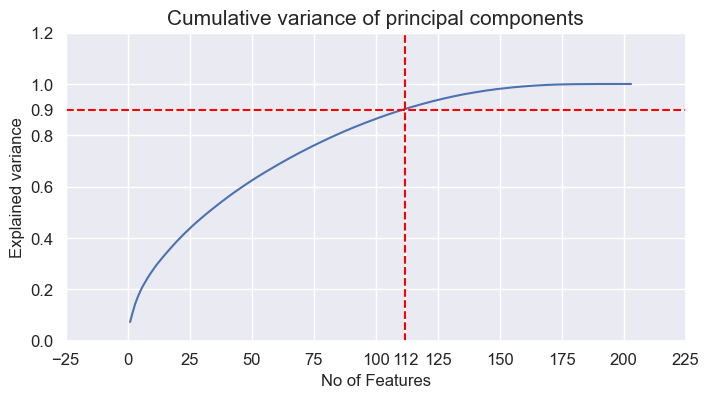

In [37]:
# Cumulaltive sum of explained variance
var_cumu = np.cumsum(pca.explained_variance_ratio_)
# Find the index where cumulative explained variance crosses 90%
index_90_percent = np.argmax(var_cumu >= 0.9)

# Plotting Cumulative Explained Variance : SCREE Plot
plt.figure(figsize=[8,4])
plt.plot(range(1,len(var_cumu)+1), var_cumu)

plt.axhline(y=0.9, color='red', linestyle='--', label='Constant Line at y=0.9')
plt.axvline(x=index_90_percent + 1, color='red', linestyle='--', label='Intersection at 90%')
# Set ticks at the intersection point
existing_xticks = plt.xticks()[0]
existing_yticks = plt.yticks()[0]
new_xticks = list(existing_xticks) + [index_90_percent + 1]
new_yticks = list(existing_yticks) + [0.9]
plt.xticks(new_xticks)
plt.yticks(new_yticks)

plt.title("Cumulative variance of principal components",size=15)
plt.ylabel("Explained variance",size=12)
plt.xlabel("No of Features",size=12)
plt.tick_params(size=5,labelsize = 12) # Tick size in both X and Y axes
plt.grid(0.3)

In [38]:
# Iniating PCA with 112 componenets
pca_final = IncrementalPCA(n_components=112)
X_train_pca = pca_final.fit_transform(X_train)
X_test_pca = pca_final.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

(1460, 112)
(1459, 112)


# Modelling

## Defining Necessary Functions

### Cross Validation

- done to avoid underfitting/overfitting of data and to get a better understanging of how good our models are performing
- split  data into k subsets, and train on k-1 of those subset,leaving one for testing
- performing 10-fold cross validation for each model

In [39]:
# calculating cross validation score with scoring set to negative mean absolute error
def cross_validation(model):
    
    scores = np.sqrt(-cross_val_score(model, X_train_pca, y_train, cv = 10, scoring = "neg_mean_squared_error"))
    mean = np.mean(scores)
    print("Mean CV score: ",mean)

### RMSE

In [40]:
# function to calculate Root mean square error (RMSE)
def rmse(y_pred, y_train): 
    
    rmse_ = np.sqrt(mean_squared_error(y_pred,y_train))
    print("rmse: ", rmse_)

### Plot Actual vs. Predicted

In [41]:
# function to plot actual vs predicited label
def actual_vs_pred_plot(y_train,y_pred):
    
    plt.figure(figsize=(6,6))
    
    plt.scatter(y_train, y_pred,color = "teal",edgecolor = 'lightblue')
    plt.plot([y_train.min(),y_train.max()], [y_train.min(), y_train.max()], 'k--',lw=0.2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.xticks(rotation=60)
    plt.suptitle("Actual vs Predicted Scatter Plot",size=14)
    plt.show()

## Linear Regression

In [42]:
reg = LinearRegression()

In [43]:
cross_validation(reg)

Mean CV score:  42883.61988341041


In [44]:
#fit on training
model_reg = reg.fit(X_train_pca, y_train)

#predict value of sale price on the training set
y1_pred = reg.predict(X_train_pca)

#caculate root mean square error
rmse(y1_pred,y_train)

rmse:  32308.6426088323


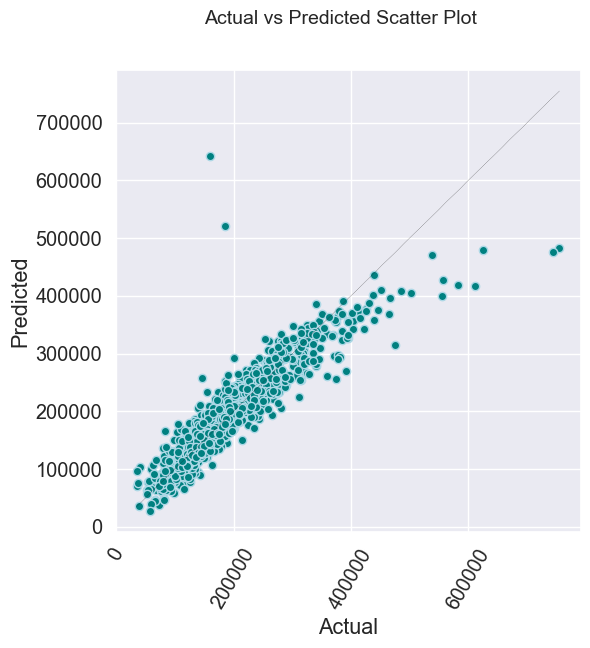

In [45]:
actual_vs_pred_plot(y_train,y1_pred)

## Ridge Regression

In [46]:
# to find the best value of alphas from this list, i will use RidgeCV
alphas_ = [ 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20]

# use robust scaler as unlike other scalers, the centering and scaling of ro bust scaler
#is based on percentiles and are therefore is not influenced by a few number of very large marginal outliers.

ridge = make_pipeline(RidgeCV(alphas = alphas_, cv = 10))

In [47]:
cross_validation(ridge)

Mean CV score:  39558.083590813694


In [48]:
#fit
model_ridge = ridge.fit(X_train_pca, y_train)

#predict value of sale price on the training set
y2_pred = ridge.predict(X_train_pca)

#caculate root mean square error
rmse(y2_pred,y_train)

rmse:  32310.117790278233


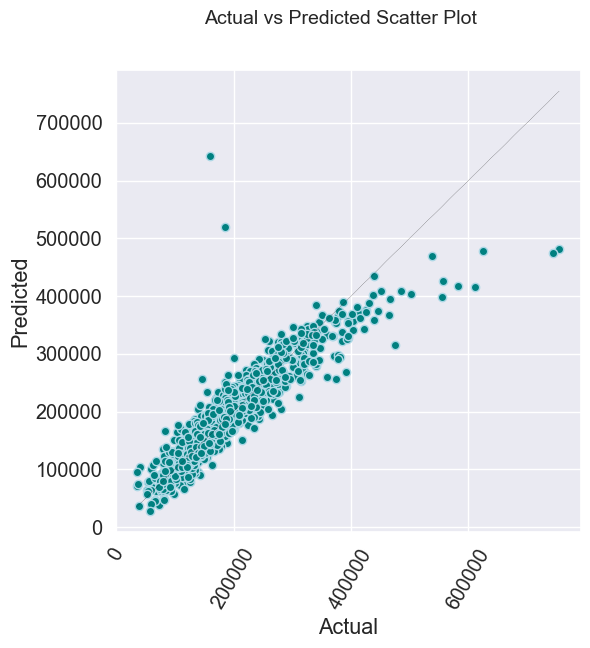

In [49]:
actual_vs_pred_plot(y_train,y2_pred)

## Lasso Regression

In [50]:
# to find the best value of alphas from this list, i will use LassoCV
alpha2 = [0.0001, 0.0002, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

#use robust scaler so that predictions are not influenced by a few number of very large marginal outliers

lasso = make_pipeline(LassoCV(alphas = alpha2, random_state=42,cv=12,max_iter=2000))

In [51]:
cross_validation(lasso)

Mean CV score:  42883.51621082115


In [52]:
#fit
model_lasso = lasso.fit(X_train_pca, y_train)

#predict value of quality on the training set
y3_pred = lasso.predict(X_train_pca)

#caculate root mean square error
rmse(y3_pred,y_train)

rmse:  32308.642608833263


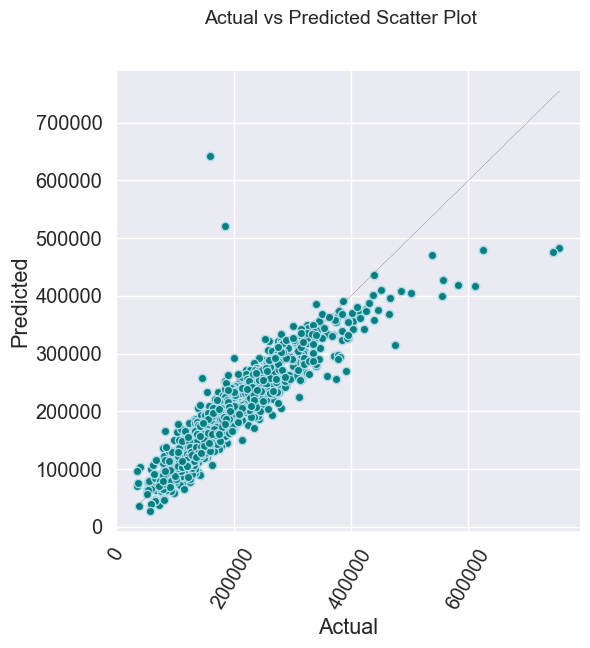

In [53]:
actual_vs_pred_plot(y_train,y3_pred)

## KNN Regression

In [54]:
knn = make_pipeline(KNeighborsRegressor(weights = 'uniform', algorithm = 'auto', leaf_size=25))
cross_validation(knn)

Mean CV score:  42440.547120911186


In [55]:
# N = 5 
neigh = KNeighborsRegressor(n_neighbors = 5,
                            weights = 'uniform',
                            algorithm = 'auto',
                            leaf_size=25)
neigh.fit(X_train_pca,y_train)

#predict value of sale price on the training set
y4_pred = neigh.predict(X_train_pca)

#caculate root mean square error
rmse(y4_pred,y_train)

rmse:  35302.41744609854


In [56]:
# N = 7
neigh1 = KNeighborsRegressor(n_neighbors = 7,
                             weights = 'uniform',
                             leaf_size=25)
neigh1.fit(X_train_pca,y_train)

#predict value of quality on the training set
y_pred = neigh1.predict(X_train_pca)

#caculate root mean square error
rmse(y_pred,y_train)

rmse:  36733.18009909044


In [57]:
# N = 9
neigh2 = KNeighborsRegressor(n_neighbors = 9,
                             weights = 'uniform',
                             leaf_size=25)
neigh2.fit(X_train_pca,y_train)

#predict value of quality on the training set
y_pred = neigh2.predict(X_train_pca)

#caculate root mean square error
rmse(y_pred,y_train)

rmse:  37821.89359622449


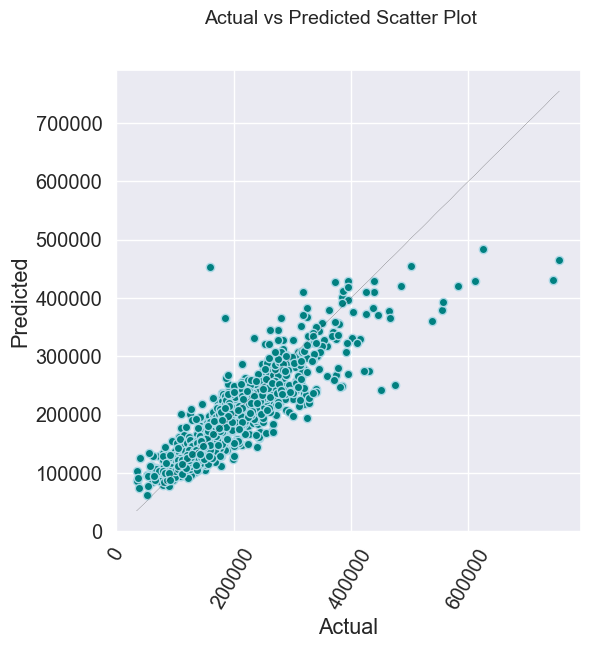

In [58]:
## N=5 is the best among the 3 built models
actual_vs_pred_plot(y_train,y4_pred)

# Model Comparison

|Model | Cross Validation (Average RMSE) | Final RMSE Train| 
|------|---------------------------------|-----------------|
| Linear reg | 42883.62 | 32308.64 |
| Ridge  | 39558.08 | 32310.11 |
| Lasso  | 42883.51 | 32308.64 |
| K-nearest neighbour | 42440.54 | 35302.41 |

# Final Conclusions

- The best model among the explored regression models is Ridge linear regression model with a cross validation RMSE of approximately 39,500. 

- Both simple linear regression and Lasso linear regression give the exact same outputs for RMSE suggesting that the L1 penalization isn't ideal, this is because the dimensionality reduction has already been done using PCA and the L1 penalization isn't dropping any extra features. 

- The KNN Regressor is the worst performer among the ones explored.

- Other models and hyperparameter tuning can potentially give better outputs. 